# Re-analysing Yim, Shao & Xu (2024) and using machine learning to learn more about glitch distributions

This notebook is for the analysis of ATNF pulsar and JBCA and ATNF glitch data. We will re-do the analysis of [Yim, Shao & Xu (2024)](https://academic.oup.com/mnras/article/532/4/3893/7712489) but using improved code, including:

- Webscrapping for data so we always have the latest updates included
- Handling the data using Pandas which makes the code more readable and execute faster
- Explore the pulsar dataset more to find what pulsar features are correlated
- Write code to determine the glitch size distribution and waiting time distribution
- Use machine learning to determine the which features can be used to predict the above distributions

The project will be divided into two main parts:

*PART I* (reproducing [Yim, Shao & Xu (2024)](https://academic.oup.com/mnras/article/532/4/3893/7712489))
- Loading the data (using the self-written Python module, <code>read_catalogues.py<code>)
- Cleaning the data
- Exploring/processing/applying mathematical models to the data
- Visualising the results

*PART II* (applying machine learning to determine glitch size and waiting time distributions)
- Determining the each pulsar's actual distribution for glitch sizes and waiting times (creating labels for training and testing)
- Processing the data so it is in a suitable format for applying machine learning models
- Applying different machine learning models
- Evaluating different machine learning models

---
## Importing libraries and modules

In [3]:
%pip install powerlaw

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import read_catalogues # Self-written

import matplotlib.pyplot as plt
import seaborn as sns

import powerlaw # For heavy-tailed power laws (powerlaw in Scipy not the right distribution), from Alstott, Bullmore & Plenz (2014) 
from scipy.stats import norm

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

---

# PART I - Re-analysing Yim, Shao & Xu (2024)

## Loading the data

Loading glitch data from the JBCA Glitch Catalogue:

In [9]:
df_glitch_JBCA = read_catalogues.read_JBCA_glitch_catalogue()
df_glitch_JBCA

,Pulsar name,J-name,No.,MJD,+/-,dF/F,+/-,dF1/F1,+/-,References
0,J0007+7303,0007+7303,1,54953,X,554,1,1.0,0.1,"Abdo+2012 [awd+12], also in Ray+2011 [rkp+11]"
1,J0007+7303,0007+7303,2,55466,X,1260,X,X,X,Belfore+2011 [3rd Fermi symp.]
2,J0040-7335,0040-7335,1,59919.7,X,1.31,0.18,0.056,0.025,New. Also in Carli+24 [cab+24]
3,J0040-7335,0040-7335,2,60355.8,X,1.9,0.4,0.68,0.11,New
4,J0040-7337,0040-7337,1,60013.13,0.05,1810,X,7,X,Carli+24 [cab+24]
...,...,...,...,...,...,...,...,...,...,...
723,1E_2259+586,2301+5852,5,54880,X,-14,1,-29.3,22.2,Icdem+2012 [ibi12]
724,B2323+63,2325+6316,1,53957,31,0.21,0.02,-0.32,0.04,Basu+2021 [bsa+21]
725,B2334+61,2337+6151,1,53642,13,20470,1,23.8,0.4,"Espinoza+2011 [elsk11], also in Yuan+2010 [ymw..."
726,J2346-0609,2346-0609,1,57495,2,0.55,0.01,2.4,0.4,Basu+2021 [bsa+21]


In [10]:
df_glitch_JBCA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Pulsar name  728 non-null    object
 1   J-name       728 non-null    object
 2   No.          728 non-null    object
 3   MJD          728 non-null    object
 4   +/-          728 non-null    object
 5   dF/F         728 non-null    object
 6   +/-          728 non-null    object
 7   dF1/F1       728 non-null    object
 8   +/-          728 non-null    object
 9   References   728 non-null    object
dtypes: object(10)
memory usage: 57.0+ KB


The JBCA Glitch Catalogue has 712 glitch entries in total across 10 different columns (2025/11/09). 728 glitch entries on 2025/12/08. We will need to convert certain columns to the correct data type, i.e. changing object (string) to float. Although there are apparently no non-null entries, we see above that any null entries are marked by a 'X'. We will make sure to change these into actual null entries shortly.

Download the ATNF files if they are not in the current working directory:

In [13]:
if not os.path.exists('psrcat_pkg.tar.gz'):
    read_catalogues.download_ATNF_catalogues()

Loading glitch data from the ATNF Glitch Catalogue:

In [15]:
df_glitch_ATNF = read_catalogues.read_ATNF_glitch_catalogue()
df_glitch_ATNF

,Name,J2000 Name,Glitch Epoch,+/-,dF_F,+/-,dF1_F1,+/-,Q,+/-,T_d,+/-,Ref.
0,J0007+7303,J0007+7303,54952.652,-,553.7,0.6,0.97,0.06,-,-,-,-,awd+12
1,B0144+59,J0147+5922,53682,15,0.056,0.003,-0.21,0.05,-,-,-,-,ywml10
2,B0154+61,J0157+6212,58283,3,2.6,0.3,-,-,-,-,-,-,bsa+22
3,J0146+6145,J0146+6145,51141,248,650,150,14,5,-,-,-,-,mks05
4,J0146+6145,J0146+6145,53809.185840,-,1630,350,5100,1100,1.1,0.3,17.0,1.1,gdk11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,J2301+5852,J2301+5852,56125,2,260,50,-2600,200,-,-,-,-,akn+13
640,B2323+63,J2325+6316,53957,31,0.21,0.02,-0.32,0.04,-,-,-,-,bsa+22
641,B2334+61,J2337+6151,53615,6,20579.4,1.2,156,4,0.0046,0.0007,21.4,0.5,ymw+10
642,-,-,-,-,-,-,-,-,0.0029,0.0001,147,2,ymw+10


In [16]:
df_glitch_ATNF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644 entries, 0 to 643
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          644 non-null    object
 1   J2000 Name    644 non-null    object
 2   Glitch Epoch  644 non-null    object
 3   +/-           644 non-null    object
 4   dF_F          644 non-null    object
 5   +/-           644 non-null    object
 6   dF1_F1        644 non-null    object
 7   +/-           644 non-null    object
 8   Q             644 non-null    object
 9   +/-           644 non-null    object
 10  T_d           644 non-null    object
 11  +/-           644 non-null    object
 12  Ref.          644 non-null    object
dtypes: object(13)
memory usage: 65.5+ KB


The JBCA Glitch Catalogue has 644 glitch entries in total across 12 different columns (2025/11/09). Still 644 on 2025/12/08. Some of these entries are for the same glitch but for several different recovery parameters, e.g. if a glitch had two recovery timescales. For these multi-exponential recovery glitches, we will treat each recovery independently.

Like before, we will need to convert certain columns to the correct data type, i.e. changing object (string) to float. Although there are apparently no non-null entries, we see above that any null entries are marked by a '-'. We will make sure to change these into actual null entries shortly.

Loading pulsar data from the ATNF Pulsar Catalogue:

In [19]:
df_pulsars = read_catalogues.read_ATNF_pulsar_catalogue()
df_pulsars

,A1,A12DOT,A1DOT,A1_2,A1_3,ASSOC,BINARY,BINCOMP,CLK,DECJ,...,T0,T0_2,T0_3,TASC,TASC_2,TAU_SC,TYPE,UNITS,W10,W50
0,None,None,None,None,None,"GRS:4FGL_J0002.8+6217[aab+22],XRS:1XSPS_J00025...",None,None,None,+62:16:09.4,...,None,None,None,None,None,None,HE[wcp+18],None,None,None
1,None,None,None,None,None,None,None,None,None,+18:34:59,...,None,None,None,None,None,None,None,None,112.1,61.3
2,None,None,None,None,None,"GRS:4FGL_J0007.0+7303[aab+22],XRS:RX_J0007.0+7...",None,None,None,+73:03:07.4,...,None,None,None,None,None,None,NRAD[aab+22],None,None,None
3,None,None,None,None,None,None,None,None,None,+08:10,...,None,None,None,None,None,None,None,None,53,13
4,None,None,None,None,None,None,None,None,TT(BIPM2019),+54:31:40,...,None,None,None,None,None,None,RRAT[dcm+23],None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4346,None,None,None,None,None,None,None,None,None,-22:51:53,...,None,None,None,None,None,None,None,None,21,9
4347,8.8929760,None,None,None,None,None,ELL1,He[mzl+23],None,+00:51:09.57,...,59258.1366884,None,None,None,None,None,None,TDB,1.7,0.5
4348,None,None,None,None,None,None,None,None,None,04:43,...,None,None,None,None,None,None,None,None,None,None
4349,None,None,None,None,None,None,None,None,TT(BIPM2019),+15:23:19,...,None,None,None,None,None,None,RRAT[dcm+23],None,None,None


In [20]:
df_pulsars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4351 entries, 0 to 4350
Columns: 162 entries, A1 to W50
dtypes: object(162)
memory usage: 5.4+ MB


We see that there are 4351 entries (pulsars) each with up to 162 features (2025/11/09). Still 4351 entries on 2025/12/08. Shortly, we will pull out only the features that are important to us. We will convert some columns into the correct data type too.

---

## Cleaning the data

### JBCA Glitch Catalogue

#### Changing header and data types

In [26]:
# Changing all X's into NaN
df_glitch_JBCA = df_glitch_JBCA.replace(['X', 'x'], pd.NA)

# Changing the column names
headers = ['pulsar_name', 'J_name', 'pulsar_glitch_number', 'MJD', 'MJD_err', 'dF_F', 'dF_F_err', 'dF1_F1', 'dF1_F1_err', 'references']
df_glitch_JBCA.columns = headers

# Changing each column to its correct data type - use Pandas dtypes as they support NaN values (native Python/NumPy does not)
dtype_map = {
    'pulsar_name' : 'string',
    'J_name' : 'string', 
    'pulsar_glitch_number' : 'Int64', 
    'MJD' : 'Float64', 
    'MJD_err' : 'Float64', 
    'dF_F' : 'Float64', 
    'dF_F_err' : 'Float64', 
    'dF1_F1' : 'Float64', 
    'dF1_F1_err' : 'Float64', 
    'references' : 'string'
}
df_glitch_JBCA = df_glitch_JBCA.astype(dtype_map)

df_glitch_JBCA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pulsar_name           728 non-null    string 
 1   J_name                727 non-null    string 
 2   pulsar_glitch_number  728 non-null    Int64  
 3   MJD                   728 non-null    Float64
 4   MJD_err               681 non-null    Float64
 5   dF_F                  726 non-null    Float64
 6   dF_F_err              708 non-null    Float64
 7   dF1_F1                610 non-null    Float64
 8   dF1_F1_err            605 non-null    Float64
 9   references            728 non-null    string 
dtypes: Float64(6), Int64(1), string(3)
memory usage: 62.0 KB


We see that there are some issues, for example, there is a missing J-name. We will correct that. There are also two glitches that do not have a dF_F reading, we will get rid of those. 

#### Finding the null J-name and correcting it

In [29]:
df_glitch_JBCA[df_glitch_JBCA['J_name'].isnull()]

,pulsar_name,J_name,pulsar_glitch_number,MJD,MJD_err,dF_F,dF_F_err,dF1_F1,dF1_F1_err,references
567,AX_1838.0-0655,<NA>,1,55010.0,4.0,1550.0,70.0,<NA>,<NA>,Kuiper+2010 [kh10]


In [30]:
df_glitch_JBCA.loc[df_glitch_JBCA['J_name'].isnull(), 'J_name'] = '1838-0655'
df_glitch_JBCA.loc[df_glitch_JBCA['pulsar_name'] == 'AX_1838.0-0655', 'pulsar_name'] = 'J1838-0655'

In [31]:
df_glitch_JBCA.loc[df_glitch_JBCA['J_name'] == '1838-0655', :]

,pulsar_name,J_name,pulsar_glitch_number,MJD,MJD_err,dF_F,dF_F_err,dF1_F1,dF1_F1_err,references
567,J1838-0655,1838-0655,1,55010.0,4.0,1550.0,70.0,<NA>,<NA>,Kuiper+2010 [kh10]


#### Finding the null dF/F values and removing them

In [33]:
df_glitch_JBCA[df_glitch_JBCA['dF_F'].isnull()]

,pulsar_name,J_name,pulsar_glitch_number,MJD,MJD_err,dF_F,dF_F_err,dF1_F1,dF1_F1_err,references
307,B1338-62,1341-6220,34,58178.0,15.0,<NA>,<NA>,<NA>,<NA>,Lower+2021 [ljd+21]
308,B1338-62,1341-6220,35,58214.0,17.0,<NA>,<NA>,<NA>,<NA>,Lower+2021 [ljd+21]


In [34]:
df_glitch_JBCA = df_glitch_JBCA.dropna(subset=['dF_F']).reset_index(drop=True)
df_glitch_JBCA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726 entries, 0 to 725
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pulsar_name           726 non-null    string 
 1   J_name                726 non-null    string 
 2   pulsar_glitch_number  726 non-null    Int64  
 3   MJD                   726 non-null    Float64
 4   MJD_err               679 non-null    Float64
 5   dF_F                  726 non-null    Float64
 6   dF_F_err              708 non-null    Float64
 7   dF1_F1                610 non-null    Float64
 8   dF1_F1_err            605 non-null    Float64
 9   references            726 non-null    string 
dtypes: Float64(6), Int64(1), string(3)
memory usage: 61.8 KB


#### Checking if all dF/F is positive, remove any rows that are not 

In [36]:
df_glitch_JBCA[df_glitch_JBCA['dF_F'] < 0]

,pulsar_name,J_name,pulsar_glitch_number,MJD,MJD_err,dF_F,dF_F_err,dF1_F1,dF1_F1_err,references
721,1E_2259+586,2301+5852,5,54880.0,<NA>,-14.0,1.0,-29.3,22.2,Icdem+2012 [ibi12]


In [37]:
df_glitch_JBCA = df_glitch_JBCA[df_glitch_JBCA['dF_F'] >= 0].reset_index(drop=True)
df_glitch_JBCA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pulsar_name           725 non-null    string 
 1   J_name                725 non-null    string 
 2   pulsar_glitch_number  725 non-null    Int64  
 3   MJD                   725 non-null    Float64
 4   MJD_err               679 non-null    Float64
 5   dF_F                  725 non-null    Float64
 6   dF_F_err              707 non-null    Float64
 7   dF1_F1                609 non-null    Float64
 8   dF1_F1_err            604 non-null    Float64
 9   references            725 non-null    string 
dtypes: Float64(6), Int64(1), string(3)
memory usage: 61.7 KB


#### Renaming the J-name of J1844+00 to J1844+0034 

In [39]:
# df_glitch_JBCA.loc[df_glitch_JBCA['J_name'] == '1844+00']

In [40]:
# df_glitch_JBCA.loc[df_glitch_JBCA['J_name'] == '1844+00', 'J_name'] = '1844+0034'

In [41]:
# df_glitch_JBCA.loc[df_glitch_JBCA['J_name'] == '1844+0034', :]

#### Adding 'J' to the start of all J-names

In [43]:
does_not_have_J = ~df_glitch_JBCA['J_name'].str.startswith('J') # Creates a Boolean mask that tests whether J_name starts with 'J', the tilde is a NOT operator so exchanges True <--> False  
df_glitch_JBCA.loc[does_not_have_J, 'J_name'] = 'J' + df_glitch_JBCA.loc[does_not_have_J, 'J_name']

df_glitch_JBCA.head()

,pulsar_name,J_name,pulsar_glitch_number,MJD,MJD_err,dF_F,dF_F_err,dF1_F1,dF1_F1_err,references
0,J0007+7303,J0007+7303,1,54953.0,<NA>,554.0,1.0,1.0,0.1,"Abdo+2012 [awd+12], also in Ray+2011 [rkp+11]"
1,J0007+7303,J0007+7303,2,55466.0,<NA>,1260.0,<NA>,<NA>,<NA>,Belfore+2011 [3rd Fermi symp.]
2,J0040-7335,J0040-7335,1,59919.7,<NA>,1.31,0.18,0.056,0.025,New. Also in Carli+24 [cab+24]
3,J0040-7335,J0040-7335,2,60355.8,<NA>,1.9,0.4,0.68,0.11,New
4,J0040-7337,J0040-7337,1,60013.13,0.05,1810.0,<NA>,7.0,<NA>,Carli+24 [cab+24]


#### Summary after cleaning

In [45]:
df_glitch_JBCA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pulsar_name           725 non-null    string 
 1   J_name                725 non-null    string 
 2   pulsar_glitch_number  725 non-null    Int64  
 3   MJD                   725 non-null    Float64
 4   MJD_err               679 non-null    Float64
 5   dF_F                  725 non-null    Float64
 6   dF_F_err              707 non-null    Float64
 7   dF1_F1                609 non-null    Float64
 8   dF1_F1_err            604 non-null    Float64
 9   references            725 non-null    string 
dtypes: Float64(6), Int64(1), string(3)
memory usage: 61.7 KB


In [46]:
df_glitch_JBCA['J_name'].nunique()

223

After cleaning, we have 725 glitches from 223 unique pulsars. Note: If we count the unique cases by MJD, we get 703 unique cases, but this is because 22 MJD values are not unique.

In [48]:
df_glitch_JBCA['MJD'].duplicated().value_counts()

MJD
False    703
True      22
Name: count, dtype: int64

In [49]:
df_glitch_JBCA[df_glitch_JBCA['MJD'].duplicated()]

,pulsar_name,J_name,pulsar_glitch_number,MJD,MJD_err,dF_F,dF_F_err,dF1_F1,dF1_F1_err,references
220,J1019-5749,J1019-5749,1,55595.0,10.0,1.33,0.4,0.12,0.22,Lower+2021 [ljd+21]
224,J1023-5746,J1023-5746,1,55043.0,8.0,3570.0,1.0,10.62,0.07,Gügercinoğlu+22 [ggyz22]; also in Belfore+2011...
255,J1112-6103,J1112-6103,3,55288.0,7.0,1793.0,1.0,6.0,2.0,Lower+2021 [ljd+21]
327,J1413-6141,J1413-6141,11,56975.0,8.0,30.0,2.0,<NA>,<NA>,Lower+2021 [ljd+21]
334,J1420-6048,J1420-6048,4,54652.0,20.0,937.1,0.3,2.95,0.01,"Weltevrede+2011 [wje11], also in Yu+2012 [ymh+..."
358,J1617-5055,J1617-5055,6,56267.0,6.0,2068.0,2.0,13.2,0.7,Lower+2021 [ljd+21]
365,B1643-43,J1646-4346,2,55288.0,7.0,8591.0,6.0,16.0,9.0,Lower+2021 [ljd+21]
366,CXO_J164710.2-455216,J1647-4552,1,53999.0,<NA>,65000.0,3000.0,<NA>,<NA>,Israel+2007 [icd+07]
388,1RXS_J1708-4009,J1708-4008,4,53366.0,<NA>,572.0,66.0,12.0,8.0,Dib+2008 [dkg08]
405,B1727-47,J1731-4744,5,56975.0,8.0,6.4,0.3,<NA>,<NA>,Lower+2021 [ljd+21]


### ATNF Glitch Catalogue

#### Changing header and data types

In [52]:
# Changing all hyphens and asterisks into NaNs
df_glitch_ATNF = df_glitch_ATNF.replace(['-', '*'], pd.NA)

# Changing the column names
headers = ['pulsar_name', 'J_name', 'MJD', 'MJD_err', 'dF_F', 'dF_F_err', 'dF1_F1', 'dF1_F1_err', 'Q', 'Q_err', 'T_d', 'T_d_err', 'references']
df_glitch_ATNF.columns = headers

# Remove '[s]' (a string) from some MJD dates and their errors (which should be float) 
df_glitch_ATNF['MJD'] = df_glitch_ATNF['MJD'].str.replace('[s]', '')
df_glitch_ATNF['MJD_err'] = df_glitch_ATNF['MJD_err'].str.replace('[s]', '')

# Changing each column to its correct data type - this throws an error since there are some letters ([s]) in the MJD values
dtype_map_2 = {
    'pulsar_name' : 'string',
    'J_name' : 'string', 
    'MJD' : 'Float64', 
    'MJD_err' : 'Float64', 
    'dF_F' : 'Float64', 
    'dF_F_err' : 'Float64', 
    'dF1_F1' : 'Float64', 
    'dF1_F1_err' : 'Float64', 
    'Q' : 'Float64', 
    'Q_err' : 'Float64', 
    'T_d' : 'Float64', 
    'T_d_err' : 'Float64', 
    'references' : 'string'
}
df_glitch_ATNF = df_glitch_ATNF.astype(dtype_map_2)

df_glitch_ATNF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644 entries, 0 to 643
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pulsar_name  626 non-null    string 
 1   J_name       626 non-null    string 
 2   MJD          626 non-null    Float64
 3   MJD_err      581 non-null    Float64
 4   dF_F         624 non-null    Float64
 5   dF_F_err     618 non-null    Float64
 6   dF1_F1       552 non-null    Float64
 7   dF1_F1_err   551 non-null    Float64
 8   Q            136 non-null    Float64
 9   Q_err        134 non-null    Float64
 10  T_d          139 non-null    Float64
 11  T_d_err      137 non-null    Float64
 12  references   644 non-null    string 
dtypes: Float64(10), string(3)
memory usage: 71.8 KB


In terms of missing data, it seems okay, but it is worth checking the errors for Q and T_d, as they each have 2 errors missing. Also, there seems to be only 626 pulsar names but 644 references. The reason for this is because some entries represent multiple recoveries of a single glitch, where each recovery component has its own row. For example, look at Vela's glitch on MJD 51559.3190:

In [54]:
df_glitch_ATNF.iloc[145:158]

,pulsar_name,J_name,MJD,MJD_err,dF_F,dF_F_err,dF1_F1,dF1_F1_err,Q,Q_err,T_d,T_d_err,references
145,B0833-45,J0835-4510,46259.0,2.0,1598.5,1.5,13.7,1.1,0.0037,0.0005,6.5,0.5,mkhr87
146,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.1541,0.0006,332.0,10.0,mkhr87
147,B0833-45,J0835-4510,47519.8036,0.00008,1805.2,0.8,77.0,6.0,0.005385,0.00001,4.62,0.02,mhmk90
148,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.1684,0.0004,351.0,1.0,mhmk90
149,B0833-45,J0835-4510,48457.4,1.0,2715.0,2.0,600.0,60.0,<NA>,<NA>,<NA>,<NA>,fla91
150,B0833-45,J0835-4510,49559.0,0.2,835.0,2.0,0.0,5.0,<NA>,<NA>,<NA>,<NA>,fla94a
151,B0833-45,J0835-4510,49591.82,<NA>,199.0,2.0,120.0,20.0,<NA>,<NA>,<NA>,<NA>,fla94b
152,B0833-45,J0835-4510,50369.345,0.002,2110.0,17.0,5.95,0.03,0.03,0.004,186.0,12.0,"wmp+00,ymh+13"
153,B0833-45,J0835-4510,51559.319,0.0005,3152.0,2.0,495.0,37.0,0.0088,0.0006,0.53,0.03,dml02
154,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.00547,0.00006,3.29,0.03,dml02


#### Ensuring each recovery component has pulsar data 

One can see that there are 4 components for the glitch with different recovery parameters (Q and T_d). To clean this, we will just copy the other data (pulsar_name, J_name, ..., dF1_F1_err) from the first component, as each component has the same properties. 

In [57]:
no_name_indices = df_glitch_ATNF[df_glitch_ATNF['pulsar_name'].isnull()].index

In [58]:
len(no_name_indices) # This gives the number of extra entries due to extra recovery components

18

In [59]:
for index in no_name_indices:
    test_index = index - 1
    df_glitch_ATNF.loc[index, 'pulsar_name': 'dF1_F1_err'] = df_glitch_ATNF.loc[test_index, 'pulsar_name': 'dF1_F1_err']

In [60]:
df_glitch_ATNF.iloc[145:158]

,pulsar_name,J_name,MJD,MJD_err,dF_F,dF_F_err,dF1_F1,dF1_F1_err,Q,Q_err,T_d,T_d_err,references
145,B0833-45,J0835-4510,46259.0,2.0,1598.5,1.5,13.7,1.1,0.0037,0.0005,6.5,0.5,mkhr87
146,B0833-45,J0835-4510,46259.0,2.0,1598.5,1.5,13.7,1.1,0.1541,0.0006,332.0,10.0,mkhr87
147,B0833-45,J0835-4510,47519.8036,0.00008,1805.2,0.8,77.0,6.0,0.005385,0.00001,4.62,0.02,mhmk90
148,B0833-45,J0835-4510,47519.8036,0.00008,1805.2,0.8,77.0,6.0,0.1684,0.0004,351.0,1.0,mhmk90
149,B0833-45,J0835-4510,48457.4,1.0,2715.0,2.0,600.0,60.0,<NA>,<NA>,<NA>,<NA>,fla91
150,B0833-45,J0835-4510,49559.0,0.2,835.0,2.0,0.0,5.0,<NA>,<NA>,<NA>,<NA>,fla94a
151,B0833-45,J0835-4510,49591.82,<NA>,199.0,2.0,120.0,20.0,<NA>,<NA>,<NA>,<NA>,fla94b
152,B0833-45,J0835-4510,50369.345,0.002,2110.0,17.0,5.95,0.03,0.03,0.004,186.0,12.0,"wmp+00,ymh+13"
153,B0833-45,J0835-4510,51559.319,0.0005,3152.0,2.0,495.0,37.0,0.0088,0.0006,0.53,0.03,dml02
154,B0833-45,J0835-4510,51559.319,0.0005,3152.0,2.0,495.0,37.0,0.00547,0.00006,3.29,0.03,dml02


#### Checking missing Q_err and T_d_err values

In [62]:
df_glitch_ATNF[df_glitch_ATNF['Q'].notnull() & df_glitch_ATNF['Q_err'].isnull()]

,pulsar_name,J_name,MJD,MJD_err,dF_F,dF_F_err,dF1_F1,dF1_F1_err,Q,Q_err,T_d,T_d_err,references
163,B0833-45,J0835-4510,58515.5929,0.0005,2501.2,3.2,8.69,0.28,0.005,<NA>,11.0,1.2,"ker19,lbs+20"
465,J1822-1604,J1822-1604,56756.0,<NA>,230.0,10.0,<NA>,<NA>,1.0,<NA>,40.0,6.0,skc14


Having checked the above rows in the raw data file, I can confirm that these rows do not have Q_err. (There is nothing wrong with how the code read in the values.)

In [64]:
df_glitch_ATNF[df_glitch_ATNF['T_d'].notnull() & df_glitch_ATNF['T_d_err'].isnull()]

,pulsar_name,J_name,MJD,MJD_err,dF_F,dF_F_err,dF1_F1,dF1_F1_err,Q,Q_err,T_d,T_d_err,references
394,B1737-30,J1740-3015,52347.66,0.06,152.0,2.0,-4.6,0.4,0.103,0.009,50.0,<NA>,zwm+08
399,B1737-30,J1740-3015,53023.52,0.0,1850.9,0.3,2.4,0.4,0.0302,0.0006,100.0,<NA>,"elsk11,zwm+08"


Having checked the above rows in the raw data file, I can confirm that these rows do not have T_d_err. (There is nothing wrong with how the code read in the values.)

#### Checking for NaNs and negative dF_F

In [67]:
df_glitch_ATNF[df_glitch_ATNF['dF_F'].isnull()]

,pulsar_name,J_name,MJD,MJD_err,dF_F,dF_F_err,dF1_F1,dF1_F1_err,Q,Q_err,T_d,T_d_err,references
254,B1338-62,J1341-6220,58178.0,15.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,ljd+21
255,B1338-62,J1341-6220,58214.0,4.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,ljd+21


In [68]:
df_glitch_ATNF = df_glitch_ATNF.dropna(subset=['dF_F']).reset_index(drop=True)

In [69]:
df_glitch_ATNF[df_glitch_ATNF['dF_F'] <= 0]

,pulsar_name,J_name,MJD,MJD_err,dF_F,dF_F_err,dF1_F1,dF1_F1_err,Q,Q_err,T_d,T_d_err,references
291,J1522-5735,J1522-5735,55250.0,<NA>,-11.4,0.6,-1.2,1.3,1.4,0.2,27.0,5.0,pga+13
636,J2301+5852,J2301+5852,56035.0,2.0,-310.0,40.0,2700.0,200.0,<NA>,<NA>,<NA>,<NA>,akn+13


In [70]:
df_glitch_ATNF = df_glitch_ATNF[df_glitch_ATNF['dF_F'] >= 0].reset_index(drop=True)

#### Summary after cleaning

In [72]:
df_glitch_ATNF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pulsar_name  640 non-null    string 
 1   J_name       640 non-null    string 
 2   MJD          640 non-null    Float64
 3   MJD_err      595 non-null    Float64
 4   dF_F         640 non-null    Float64
 5   dF_F_err     634 non-null    Float64
 6   dF1_F1       568 non-null    Float64
 7   dF1_F1_err   567 non-null    Float64
 8   Q            135 non-null    Float64
 9   Q_err        133 non-null    Float64
 10  T_d          138 non-null    Float64
 11  T_d_err      136 non-null    Float64
 12  references   640 non-null    string 
dtypes: Float64(10), string(3)
memory usage: 71.4 KB


In [73]:
df_glitch_ATNF['J_name'].nunique()

210

After cleaning, we have 640 entries (each glitch recovery component is one entry) from 210 unique pulsars. As we saw earlier, 18 of these entries are due to extra recovery components, so the ATNF Glitch Catalogue actually contains 622 glitches from 210 unique pulsars. 

Note: If we count the unique number of combinations of 'J_name' and 'MJD', we actually get 621. This is because there is one glitch, from J1801-2451 that has been entered twice (presumably from two different groups/analyses). For our purposes here, we will say that these two entries correspond to just one glitch.

In [75]:
df_glitch_ATNF[['J_name', 'MJD']].drop_duplicates().shape[0]

621

In [76]:
df_glitch_ATNF[df_glitch_ATNF[['J_name', 'MJD']].duplicated()] # Displays duplicated entries

,pulsar_name,J_name,MJD,MJD_err,dF_F,dF_F_err,dF1_F1,dF1_F1_err,Q,Q_err,T_d,T_d_err,references
36,B0531+21,J0534+2200,42447.26,0.04,35.7,0.3,1.6,0.1,0.536,0.012,97.0,4.0,lps93
38,B0531+21,J0534+2200,46663.69,0.03,6.0,1.0,0.5,0.1,0.89,0.09,123.0,40.0,lps93
133,B0833-45,J0835-4510,40280.0,4.0,2338.0,9.0,10.1,0.3,0.01782,0.00005,120.0,6.0,cdk88
135,B0833-45,J0835-4510,41192.0,8.0,2047.0,30.0,14.8,0.2,0.01311,0.00009,94.0,5.0,cdk88
138,B0833-45,J0835-4510,42683.0,3.0,1987.0,8.0,11.0,1.0,0.003534,0.000016,35.0,2.0,cdk88
140,B0833-45,J0835-4510,43693.0,12.0,3063.0,65.0,18.3,0.2,0.01134,0.00002,75.0,3.0,cdk88
142,B0833-45,J0835-4510,44888.4,0.4,1138.0,9.0,8.43,0.06,0.0019,0.00004,14.0,2.0,cdk88
144,B0833-45,J0835-4510,45192.1,0.5,2051.0,3.0,23.1,0.3,0.0055,0.00008,21.5,2.0,cdk88
146,B0833-45,J0835-4510,46259.0,2.0,1598.5,1.5,13.7,1.1,0.1541,0.0006,332.0,10.0,mkhr87
148,B0833-45,J0835-4510,47519.8036,0.00008,1805.2,0.8,77.0,6.0,0.1684,0.0004,351.0,1.0,mhmk90


In [77]:
df_glitch_ATNF[(df_glitch_ATNF['J_name'] == 'J1801-2451') & (df_glitch_ATNF['MJD'] == 54661)]

,pulsar_name,J_name,MJD,MJD_err,dF_F,dF_F_err,dF1_F1,dF1_F1_err,Q,Q_err,T_d,T_d_err,references
422,B1757-24,J1801-2451,54661.0,2.0,3101.0,1.0,9.3,0.1,0.0064,0.0009,25.0,4.0,"elsk11,ymh+13"
437,B1757-24,J1801-2451,54661.0,2.0,3083.7,0.7,6.5,0.5,<NA>,<NA>,<NA>,<NA>,ljd+21


Moreover, we have 135 entries that have a Q value, coming from 117 glitches of 60 unique pulsars.

In [79]:
df_glitch_ATNF[df_glitch_ATNF['Q'].notnull()].nunique()

pulsar_name     60
J_name          60
MJD            115
MJD_err         47
dF_F           117
dF_F_err        42
dF1_F1          86
dF1_F1_err      38
Q              112
Q_err           54
T_d            116
T_d_err         63
references      43
dtype: int64

### ATNF Pulsar Catalogue

#### Setting correct data types

In [82]:
df_pulsars = df_pulsars.convert_dtypes() # Without this line, we only get Float64 columns. We get both Float64 and Int64 with it. All 'None' values are set to pd.NA.
df_pulsars = df_pulsars.apply(pd.to_numeric, errors='ignore') # Converts columns to appropriate data type, if not numeric, column stays as string

/var/folders/_b/pgn_02kj1wn6dy5hlf5x9_5r0000gn/T/ipykernel_22635/2893375758.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_pulsars = df_pulsars.apply(pd.to_numeric, errors='ignore') # Converts columns to appropriate data type, if not numeric, column stays as string


In [83]:
df_pulsars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4351 entries, 0 to 4350
Columns: 162 entries, A1 to W50
dtypes: Float64(140), Int64(8), string(14)
memory usage: 6.0 MB


We see that we initially have 140 columns that are floats, 8 that are integers and 14 that are strings. We will check the integer and string columns to ensure they do not have any columns that should be floats.

In [85]:
int_columns = df_pulsars.select_dtypes(include='int')
int_columns[int_columns.notnull().any(axis = 1)] # Shows only non-null rows

,NGLT,S35,S40,S50,S60,S64,S79,S80
2,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
5,<NA>,<NA>,<NA>,43,<NA>,<NA>,<NA>,<NA>
37,<NA>,<NA>,<NA>,86,<NA>,<NA>,<NA>,<NA>
41,<NA>,<NA>,<NA>,900,<NA>,<NA>,<NA>,<NA>
42,<NA>,<NA>,<NA>,600,<NA>,<NA>,<NA>,5000
...,...,...,...,...,...,...,...,...
4321,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4329,<NA>,<NA>,<NA>,111,<NA>,<NA>,<NA>,250
4334,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4339,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


The 8 columns consist of the number of glitches (NGLT) and the mean fluxes (in mJy) at several frequencies (in MHz). To be consistent with the other mean fluxes, e.g. S400, S1400, S2000, we will convert the mean flux columns to floats.

In [87]:
int_to_float_col = int_columns.loc[:, int_columns.columns.str.startswith('S')].columns # Getting the names of the integer columns beginning with S
df_pulsars[int_to_float_col] = df_pulsars[int_to_float_col].astype('Float64')

We will now look at the string columns.

In [89]:
str_columns = df_pulsars.select_dtypes(include='string')
str_columns

,ASSOC,BINARY,BINCOMP,CLK,DECJ,EPHEM,PSRB,PSRJ,RAJ,SURVEY,TYPE,UNITS,W10,W50
0,"GRS:4FGL_J0002.8+6217[aab+22],XRS:1XSPS_J00025...",<NA>,<NA>,<NA>,+62:16:09.4,<NA>,<NA>,J0002+6216,00:02:58.17,FermiBlind,HE[wcp+18],<NA>,<NA>,<NA>
1,<NA>,<NA>,<NA>,<NA>,+18:34:59,<NA>,<NA>,J0006+1834,00:06:04.8,"ar4,ar327,fast_gpps",<NA>,<NA>,112.1,61.3
2,"GRS:4FGL_J0007.0+7303[aab+22],XRS:RX_J0007.0+7...",<NA>,<NA>,<NA>,+73:03:07.4,<NA>,<NA>,J0007+7303,00:07:01.7,FermiBlind,NRAD[aab+22],<NA>,<NA>,<NA>
3,<NA>,<NA>,<NA>,<NA>,+08:10,<NA>,<NA>,J0011+08,00:11:34,"ar327,fast_gpps",<NA>,<NA>,53,13
4,<NA>,<NA>,<NA>,TT(BIPM2019),+54:31:40,DE440,<NA>,J0012+5431,00:12:23.3,chime,RRAT[dcm+23],<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4346,<NA>,<NA>,<NA>,<NA>,-22:51:53,<NA>,<NA>,J2354-2250,23:54:26,"htru_pks,gbncc",<NA>,<NA>,21,9
4347,<NA>,ELL1,He[mzl+23],<NA>,+00:51:09.57,DE438,<NA>,J2355+0051,23:55:51.2885,"fast_crafts,ar327",<NA>,TDB,1.7,0.5
4348,<NA>,<NA>,<NA>,<NA>,04:43,<NA>,<NA>,J2355+04,23:55:30,pumps,<NA>,<NA>,<NA>,<NA>
4349,<NA>,<NA>,<NA>,TT(BIPM2019),+15:23:19,DE440,<NA>,J2355+1523,23:55:48.62,chime,RRAT[dcm+23],<NA>,<NA>,<NA>


From the string columns above, we see that W10 and W50 should both be floats. Also, it would be better to express the declination (DECJ) and right ascension (RAJ) as an angle rather than in dd:mm:ss (degrees, minutes, seconds) and hh:mm:ss (hours, minutes, seconds), respectively.

First, we change W10 and W50 columns to floats. The underlying issue was that pd.to_numeric did not convert strings in scientific notation, e.g. '1.3e+02', or perhaps it was struggling with the string 'nan', so we've had to use .astype('Float64') instead.

In [91]:
df_pulsars[['W10', 'W50']] = df_pulsars[['W10', 'W50']].astype('Float64')
df_pulsars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4351 entries, 0 to 4350
Columns: 162 entries, A1 to W50
dtypes: Float64(149), Int64(1), string(12)
memory usage: 6.0 MB


#### Converting `DECJ` and `RAJ` columns to degrees (`DEC` and `RA`)

We will now write two functions to convert DECJ and RAJ into degrees:

In [94]:
def convert_decj_to_deg(decj): # decj is a string in the format 'dd:mm:ss' or 'dd:mm' or 'mm' with a plus, minus or nothing in front
    dec_deg = []
    if pd.notna(decj):
        split_string = decj.split(':')
        if split_string[0][0] == '+': # If first character is a plus symbol
            split_string[0] = split_string[0][1:] # Remove the plus symbol
        float_string = list(map(float, split_string))

        degrees = abs(float_string[0])
        arcminutes = float_string[1] if len(float_string) > 1 else 0
        arcseconds = float_string[2] if len(float_string) > 2 else 0

        angle = degrees + (arcminutes/60.0) + (arcseconds/3600.0)

        if float_string[0] < 0:
            angle = -angle
        
        dec_deg.append(angle)
    else:
        dec_deg.append(pd.NA)

    return dec_deg[0]

In [95]:
df_pulsars['DEC'] = df_pulsars['DECJ'].apply(convert_decj_to_deg).astype('Float64')

In [96]:
df_pulsars[['DECJ', 'DEC']]

,DECJ,DEC
0,+62:16:09.4,62.269278
1,+18:34:59,18.583056
2,+73:03:07.4,73.052056
3,+08:10,8.166667
4,+54:31:40,54.527778
...,...,...
4346,-22:51:53,-22.864722
4347,+00:51:09.57,0.852658
4348,04:43,4.716667
4349,+15:23:19,15.388611


In [97]:
def convert_raj_to_deg(raj): # raj is a string in the format 'hh:mm:ss' or 'hh:mm'
    raj_deg = []
    if pd.notna(raj):
        split_string = raj.split(':')
        float_string = list(map(float, split_string))

        hours = float_string[0]
        minutes = float_string[1]
        seconds = float_string[2] if len(float_string) > 2 else 0

        angle = hours * (360.0/24.0) + minutes * (360.0/(24.0 * 60.0)) + seconds * (360.0/(24.0 * 60.0 * 60.0))

        raj_deg.append(angle)
    else:
        raj_deg.append(pd.NA)
        
    return raj_deg[0]

In [98]:
df_pulsars['RA'] = df_pulsars['RAJ'].apply(convert_raj_to_deg).astype('Float64')

In [99]:
df_pulsars[['RAJ', 'RA']]

,RAJ,RA
0,00:02:58.17,0.742375
1,00:06:04.8,1.52
2,00:07:01.7,1.757083
3,00:11:34,2.891667
4,00:12:23.3,3.097083
...,...,...
4346,23:54:26,358.608333
4347,23:55:51.2885,358.963702
4348,23:55:30,358.875
4349,23:55:48.62,358.952583


## Combining datasets

### Comparing JBCA and ATNF Glitch Catalogues

#### Pulsars in both databases

In [103]:
s1 = set(df_glitch_JBCA['J_name'])
s2 = set(df_glitch_ATNF['J_name'])
s3 = set(df_pulsars['PSRJ'])

In [104]:
pulsars_in_both = s1 & s2
len(pulsars_in_both)

189

#### Pulsars in JBCA but missing from ATNF

In [106]:
in_JBCA_not_ATNF = s1 - s2
len(in_JBCA_not_ATNF)

34

In [107]:
in_JBCA_not_ATNF

{'J0040-7335',
 'J0040-7337',
 'J0048-7317',
 'J0726-2612',
 'J0738-4042',
 'J0855-3331',
 'J0955+6940',
 'J1048-5937',
 'J1341-6023',
 'J1647-4552',
 'J1730-3353',
 'J1809-0119',
 'J1821-1419',
 'J1828-1101',
 'J1832+0029',
 'J1835-0024',
 'J1838-0537',
 'J1838-0655',
 'J1843-0509',
 'J1844-0310',
 'J1849-0001',
 'J1849-0636',
 'J1854-1557',
 'J1904-1629',
 'J1907+0602',
 'J1914+1122',
 'J1935+1616',
 'J1935+2025',
 'J1948+2819',
 'J1949-2524',
 'J1955+2529',
 'J2004+3427',
 'J2022+2854',
 'J2111+4606'}

Appendix C of Yim, Shao & Xu (2024) found 19 pulsars, 17 of which are identified above. 2 that are no longer found have been corrected by JBCA (J1635-2614 --> J1636-2614, M82-X2 --> J0955+6940). That means that there are 17 new pulsars that have been added to the JBCA Glitch Catalogue since July 2024 (when the paper was published) that haven't been added to the ATNF Glitch Catalogue.

#### Pulsars in ATNF but missing from JBCA

In [110]:
in_ATNF_not_JBCA = s2 - s1
len(in_ATNF_not_JBCA)

21

In [111]:
in_ATNF_not_JBCA

{'J0908-4913',
 'J0954-5430',
 'J1015-5719',
 'J1050-5953',
 'J1141-6545',
 'J1422-6138',
 'J1550-5418',
 'J1602-5100',
 'J1645-0317',
 'J1703-4851',
 'J1706-4434',
 'J1722-3632',
 'J1822-1604',
 'J1844-0346',
 'J1852-0635',
 'J1906+0722',
 'J1910+1026',
 'J1915+1150',
 'J1939+2609',
 'J1947+1957',
 'J1954+2529'}

The above pulsars are exactly the same as what was identified in Appendix C of Yim, Shao & Xu (2024) except for one that is missing. The missing pulsar is J1636-2614 which has since been corrected by JBCA (J1635-2614 --> J1636-2614), making it consistent with the ATNF databases.

#### Pulsars in JBCA Glitch Catalogue but not in ATNF Pulsar Catalogue

In [114]:
in_JBCA_not_pulsars = s1 - s3
len(in_JBCA_not_pulsars)

6

In [115]:
in_JBCA_not_pulsars

{'J0955+6940',
 'J1048-5937',
 'J1835-0024',
 'J1843-0509',
 'J1955+2529',
 'J2004+3427'}

These pulsars have not had their information added to the ATNF Pulsar Catalogue yet.

#### Pulsars in ATNF Glitch Catalogue but not in ATNF Pulsar Catalogue

In [118]:
in_ATNF_not_pulsars = s2 - s3
len(in_ATNF_not_pulsars)

0

There are no pulsars in the ATNF Glitch Catalogue which is not already in the ATNF Pulsar Catalogue, which was to be expected.

### Creating a master glitch dataset `df_glitch` from JBCA and ATNF Glitch Catalogues

This master dataset `df_glitch` will combine the JBCA and ATNF Glitch Catalogues, with the values from the JBCA Glitch Catalogue taking priority over the ATNF Glitch Catalogue. We will do an outer join of the two catalogues, on the columns `J_name` and `MJD`, to ensure we keep all `J_name` and `MJD` combinations found in the databases. Doing this also retains all $Q$ and $\tau$ values. 

The result of this outer join sometimes gives two entries for a single glitch, where each respective database gives a slightly different `MJD` for a given glitch. In other words, identical glitches between databases have rounding/reporting differences, e.g. glitch from J2337+6151 (MJD = 53642 in JBCA and MJD = 53615 in ATNF). To combat this, we will need to match MJD values to within some tolerance (call it $\pm$50 days).

Knowing this, we pull out from this outer-joined dataframe the glitches that do not need further processing, which include:
- Glitches that have exactly the same `J_name` and `MJD`
- Recovery components that have `MJD_diff = 0` 

This leaves the entries that need pairing across the two databases, which we hold in `df_alter`. We further split `df_alter` into `df_pairs`, which only has 1 entry from each database (so the pairing is obvious), and `df_not_pairs`, where we can have more than 1 entry from either database. We create an algorithm (logic provided in the code) to deal with `df_not_pairs`.

After entries are matched by MJD to within a tolerance, the entries from are moved from `df_pairs` and `df_not_pairs` to `df_matched`, which then gets appended onto `df_glitch` which is the final combined database.

The total unique pulsars in the glitch catalogues is 244, with 189 of them in both, 34 in only JBCA and 29 in only ATNF. For the pulsars only in one catalogue, the 34 in JBCA is responsible for 44 glitches and the 21 in the ATNF is responsible for 29 glitches. In total, there are 55 pulsars that are in only one catalogue, responsible for 73 glitches in total.

The total number of glitches (in both databases or just one) is hard to say, as it depends on matching the MJD values which are inconsistent. For example, J2337+6151 has a glitch in the JBCA catalogue on MJD = 53642 but has MJD = 53615 in the ATNF catalogue (difference of 27 days). We can still connect the two if we choose a suitable tolerance. After experimenting, the best choice appears to be 50 days, as it allows almost every unique pulsar to be filtered through the cleaning process. The only pulsar not to make it through is J1841-0345, which has a glitch at MJD 56863 in the JBCA catalogue and a glitch at MJD 58455 in the ATNF catalogue. These are two separate glitches but only one glitch appears in each of their respective catalogues. 

In [122]:
# Outer join on 'J_name' and 'MJD' ensures every possible value is kept. Any matching 'J_name' and 'MJD' gets combined into one row, with extra columns ending in '_JBCA' and '_ATNF'. If there isn't a match, then pd.NA is used in either '_JBCA' columns or '_ATNF' columns. 
df_outer = df_glitch_JBCA.merge(df_glitch_ATNF, how = 'outer', on = ['J_name', 'MJD'], suffixes = ('_JBCA', '_ATNF'), indicator = True)

# Glitches in both catalogues: there are 464 glitches that have exactly the same J-name and MJD
in_both = df_outer[df_outer['_merge'] == 'both']
in_both.columns = in_both.columns.str.replace('_JBCA', '', regex = False) # Setting _JBCA columns as default
columns_to_drop = in_both.columns[in_both.columns.str.endswith('_ATNF')] # Dropping _ATNF columns (keeps Q and tau as they do not have suffix)
in_both = in_both.drop(columns = columns_to_drop)
# in_both.info() # 464 glitches (MJD), 90 Q

# Glitches only in ATNF catalogue (MJD will need comparing to JBCA to within some tolerance to see if same glitch)
ATNF_only = df_outer[df_outer['_merge'] == 'right_only']
ATNF_only.columns = ATNF_only.columns.str.replace('_ATNF', '', regex = False) # Setting _ATNF columns as default since _JBCA columns are empty
columns_to_drop = ATNF_only.columns[ATNF_only.columns.str.endswith('_JBCA')] # Dropping empty _JBCA columns
ATNF_only = ATNF_only.drop(columns = columns_to_drop)
# ATNF_only.info() # 176 glitches (MJD), 45 Q

# Glitches only in JBCA catalogue (MJD will need comparing to JBCA to within some tolerance to see if same glitch)
JBCA_only = df_outer[df_outer['_merge'] == 'left_only']
JBCA_only.columns = JBCA_only.columns.str.replace('_JBCA', '', regex = False) # Setting _JBCA columns as default since _ATNF columns are empty
columns_to_drop = JBCA_only.columns[JBCA_only.columns.str.endswith('_ATNF')] # Dropping empty _ATNF columns
JBCA_only = JBCA_only.drop(columns = columns_to_drop)
# JBCA_only.info() # 275 glitches (MJD), 0 Q

# Combining into one master glitch dataframe
df_glitch = pd.concat([in_both, ATNF_only, JBCA_only]) # Contains all 244 unique pulsars and 135 Q values (915 rows in total)

# Calculating the MJD difference between adjacent glitches for a given pulsar
df_glitch = df_glitch.sort_values(by = ['J_name', 'MJD']) # Need to sort in ascending order first, otherwise .diff gives negative values
df_glitch['MJD_diff'] = df_glitch.groupby('J_name')['MJD'].diff() # First glitch of each pulsar is assigned pd.NA

# For ease of reading
df_glitch = df_glitch.drop(columns = ['pulsar_name', 'references'])

###############################

# Glitches that that need MJD matching removed from df_glitch and contained in df_alter
df_alter = df_glitch[df_glitch['_merge'] != 'both'] # 451 rows, contains rows to alter
df_glitch = df_glitch.drop(df_alter.index) # 464 rows, will concatenate corrected rows to df_glitch after altering

###############################

# Glitches with MJD_diff = 0 are extra recovery components which we want to keep (move to df_glitch)
rows_to_move = df_alter[df_alter['MJD_diff'] == 0] 
df_glitch = pd.concat([df_glitch, rows_to_move]) # 469 rows
df_alter = df_alter.drop(rows_to_move.index) # 446 rows

###############################

# Finding pairs of glitches (via indices) with MJD_diff less than some tolerance 
tolerance = 50
df_alter = df_alter.reset_index(drop = True) # Need to reset otherwise selecting indices won't work
indices_with_small_MJD_diff = df_alter[df_alter['MJD_diff'] < tolerance].index # Finds all row indices with MJD_diff less than tolerance (difference relative to previous row) 
indices_of_comparison = indices_with_small_MJD_diff - 1 # Indices of prior row
indices_to_alter = indices_with_small_MJD_diff.union(indices_of_comparison) # All pairs of indices to be taken out and processed, 239 rows

# Selecting rows to alter and those to concatenate to df_glitch
indices_to_keep = pd.Index(range(0, len(df_alter)))
indices_to_keep = indices_to_keep.drop(indices_to_alter)
rows_to_move = df_alter.iloc[indices_to_keep]
df_glitch = pd.concat([df_glitch, rows_to_move]) # 676 rows
df_alter = df_alter.drop(rows_to_move.index) # 239 rows, these are the rows where pairs will be collated into a single row if same glitch

# For each J_name, counting how many glitches should be in each group (identified by number of pulsar_glitch_number entries that are not pd.NA)
merge_counts = df_alter.groupby('J_name')['_merge'].count() # How many entries per group
pulsar_glitch_number_count = df_alter.groupby('J_name')['pulsar_glitch_number'].count() # How many glitches there should be per group

# If the number of entries is twice the number of glitches that should be in the group, it is a simple case of matching left_only and right_only entries (forms pairs)
pair_condition = (pulsar_glitch_number_count * 2 - merge_counts == 0) # number_of_glitches tells us how many glitches there should be, _merge will be 2 times the number of glitches (1 from left_only, 1 from right_only)
pair_condition = pd.DataFrame(pair_condition)
pair_condition = pair_condition.reset_index(drop = False) # J_name was index previously, now is standard index by row number
pair_condition.columns = ['J_name', 'pair']

# Added pair column to dataframe to identify if paired
df_alter = df_alter.merge(pair_condition, how = 'inner', on = 'J_name') 

###############################

# Dataframe to hold glitches that have had their MJD matched between databases
df_matched = pd.DataFrame() 

# Dealing with pairs
df_pairs = df_alter[df_alter['pair'] == True].copy() # 154 rows, The .copy() ensures a hard copy is made so future changes do not affect df_alter
# df_pairs ### PRINT THIS IF YOU WANT A LIST OF GLITCHES THAT DIFFER BETWEEN THE TWO DATABASES ### 
# Note: two of the biggest dF_F differences is J1709-4429's glitch on MJD 58176 and J2301+5852 glitch on MJD 54184.9032 

# Dealing with each pair at a time
for i in range(0, int(len(df_pairs)/2)):
    # Takes the first 2 rows of df_pairs and drops it from df_pairs
    single_pair = df_pairs.head(2) 
    df_pairs = df_pairs.drop(single_pair.index)

    # Classifying each row into either from JBCA or ATNF
    JCBA = single_pair[single_pair['_merge'] == 'left_only']
    ATNF = single_pair[single_pair['_merge'] == 'right_only']

    # Taking certain columns from JBCA and the rest from ATNF to form a combined row, then appending that combined row to df_matched
    combined_row = pd.concat([JCBA.loc[:, 'J_name':'dF1_F1_err'].reset_index(drop = True), ATNF.loc[:, 'Q':'MJD_diff'].reset_index(drop = True)], axis = 1)
    df_matched = pd.concat([df_matched, combined_row], ignore_index = True)

###############################

# Dealing with glitches where there is not the same of left_only and right_only entries per pulsar (some entries will not need matching, it's just that it was within the MJD tolerance so was flagged, e.g. a frequent glitcher)
df_not_pairs = df_alter[df_alter['pair'] == False].copy() # 85 rows, 33 with right_only (ANTF), 4 unique pulsars
df_not_pairs = df_not_pairs.reset_index(drop = True)

# Logic:
# - Identify the glitches that need matching by looking at _merge == right_only (these come from ATNF). 
# - Get indices of all these rows, say index i. 
# - Test MJD_diff for i and i+1 (unless final row, where you test i-1) and select the row with the smallest MJD_diff (treat pd.NA as a large number).
# - If i has lowest MJD_diff, then JBCA is i-1 and ATNF is i
# - If i+1 has lowest MJD_diff, then JBCA is i+1 and ATNF is i

# I think I can use the above algorithm to sort all the df_alter glitches, not just the non-paired ones!

# Getting indices of ATNF entries and the indices of the following entry
indices_ATNF = df_not_pairs[df_not_pairs['_merge'] == 'right_only'].index
indices_test = indices_ATNF + 1

# Scenario where last entry in df_not_pairs comes from ATNF, the test index (the next index) will be out of bounds, instead, compare to 2nd from last entry 
if indices_test[-1] == len(df_not_pairs): # If the last index in the indices_to_test is out of bounds, then test the 2nd to last row
    indices_test = pd.Index(list(indices_test[:-1]) + [len(df_not_pairs) - 2])

# Pairing up ATNF indices with test indices
indices_test_MJD_diff = zip(indices_ATNF, indices_test) 

ATNF_indices = list(indices_ATNF)
JBCA_indices = []

for pair in indices_test_MJD_diff:
    ATNF_index = pair[0]
    test_index = pair[1]
    
    ATNF_MJD_diff = df_not_pairs.loc[ATNF_index, 'MJD_diff']
    test_MJD_diff = df_not_pairs.loc[test_index, 'MJD_diff']
    
    if ATNF_MJD_diff < test_MJD_diff:
        JBCA_index = ATNF_index - 1
    else:
        JBCA_index = ATNF_index + 1

    JBCA_indices.append(JBCA_index)
    
df_needs_pairing = df_not_pairs.iloc[ATNF_indices + JBCA_indices].sort_index()

indices_to_move = pd.Index(range(len(df_not_pairs))).drop(df_needs_pairing.index)

# Moving rows over to df_glitch, dropping from df_not_pairs to leave rows that need pairing
rows_to_move = df_not_pairs.iloc[indices_to_move] # 19 rows
df_glitch = pd.concat([df_glitch, rows_to_move]) # 695 rows
df_not_pairs = df_not_pairs.drop(rows_to_move.index) # 66 rows

# Dealing with each pair at a time
for i in range(0, int(len(df_not_pairs)/2)):
    # Takes the first 2 rows of df_pairs and drops it from df_not_pairs
    single_pair = df_not_pairs.head(2) 
    df_not_pairs = df_not_pairs.drop(single_pair.index)
    
    # Classifying each row into either from JBCA or ATNF
    JCBA = single_pair[single_pair['_merge'] == 'left_only']
    ATNF = single_pair[single_pair['_merge'] == 'right_only']
    
    # Taking certain columns from JBCA and the rest from ATNF to form a combined row, then appending that combined row to df_matched
    combined_row = pd.concat([JCBA.loc[:, 'J_name':'dF1_F1_err'].reset_index(drop = True), ATNF.loc[:, 'Q':'MJD_diff'].reset_index(drop = True)], axis = 1)
    df_matched = pd.concat([df_matched, combined_row], ignore_index = True) # df_matched now has 110 glitches 

###############################

# Combining df_matched (all the processed glitches) with df_glitch
df_glitch = pd.concat([df_glitch, df_matched]) # 805 rows, 135 Q, 244 unique pulsars, 805 glitches 
df_glitch = df_glitch.sort_values(by = ['J_name', 'MJD'])
df_glitch = df_glitch.reset_index(drop = True)
df_glitch = df_glitch.drop(columns = ['MJD_diff', 'pair'])
# df_glitch['_merge'].value_counts() # 464 rows in both (with MJD exactly matching), 110 from both (with MJD almost the same), 165 from JBCA only, 66 from ATNF only


In [123]:
df_glitch.head(30)

,J_name,pulsar_glitch_number,MJD,MJD_err,dF_F,dF_F_err,dF1_F1,dF1_F1_err,Q,Q_err,T_d,T_d_err,_merge
0,J0007+7303,1,54953.0,<NA>,554.0,1.0,1.0,0.1,<NA>,<NA>,<NA>,<NA>,right_only
1,J0007+7303,2,55466.0,<NA>,1260.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,left_only
2,J0040-7335,1,59919.7,<NA>,1.31,0.18,0.056,0.025,<NA>,<NA>,<NA>,<NA>,left_only
3,J0040-7335,2,60355.8,<NA>,1.9,0.4,0.68,0.11,<NA>,<NA>,<NA>,<NA>,left_only
4,J0040-7337,1,60013.13,0.05,1810.0,<NA>,7.0,<NA>,<NA>,<NA>,<NA>,<NA>,left_only
5,J0048-7317,1,59707.46,0.02,1950.0,<NA>,7.0,<NA>,<NA>,<NA>,<NA>,<NA>,left_only
6,J0146+6145,1,51141.0,248.0,650.0,150.0,14.0,5.0,<NA>,<NA>,<NA>,<NA>,both
7,J0146+6145,2,53809.0,<NA>,1627.0,348.0,11.6,0.4,1.1,0.3,17.0,1.1,right_only
8,J0146+6145,<NA>,55771.1906,<NA>,4440.0,40.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,right_only
9,J0147+5922,1,53682.0,15.0,0.056,0.003,-0.21,0.05,<NA>,<NA>,<NA>,<NA>,both


### Adding pulsar information from `df_pulsar` to each glitch in `df_glitch`

The ATNF Pulsar Catalogue is kept in the dataframe `df_pulsars`. We will now add columns to `df_glitch` that represent the frequency, frequency derivative, distance, etc. of the pulsars that are glitching.

In [126]:
df_pulsars = df_pulsars.rename(columns = {'PSRJ' : 'J_name'}) # Need to rename column for merge

In [127]:
# To print out all the names of the columns of df_pulsars
# for column in df_pulsars.columns:
#     print(column)

In `df_pulsars`, there are 6 different measures of distance: `DIST_A`, `DIST_AMN`, `DIST_AMX`, `DIST_DM`, `DIST_DM1`, `PX`. According to the ATNF Pulsar Catalogue's documentation, they represent:
- `DIST_A`: A distance derived from an association, e.g. supernova remnant, globular cluster, LMC/SMC
- `DIST_AMN` and `DIST_AMX`: Some lower and upper limit for the distance
- `DIST_DM`: A distance derived from dispersion measure using the YMW16 electron-density model (from 2016)
- `DIST_DM1`: A distance derived from dispersion measure using the NE2001 electron-density model (from 2001)
- `PX`: Annual parallax angle (in milliarcseconds), 1/PX gives the distance in kpc

The ATNF Pulsar Catalogue reports `DIST` which is the distance determined by some ordered priority:
1. `DIST_A`
2. Distance derived from 1/`PX`
3. `DIST_DM` (majority of distances come from this)
4. Mid-point between `DIST_AMN` and `DIST_AMX`
5. `DIST_DM1`

ATNF do not give `DIST` in their database so we will have to calculate it according to the above rules.

In [129]:
# Calculating 'DIST' according to above rules
df_pulsars['DIST'] = (
    df_pulsars['DIST_A']
    .fillna((1.0 / df_pulsars['PX']).where(df_pulsars['PX'] > 0)) # Some values of PX were negative 
    .fillna(df_pulsars['DIST_DM'])
    .fillna((df_pulsars['DIST_AMN'] + df_pulsars['DIST_AMX']) / 2.0)
    .fillna(df_pulsars['DIST_DM1'])
)

In [130]:
# df_pulsars[df_pulsars['DIST'].isna()].loc[:, ['J_name', 'DIST_A', 'DIST_AMN', 'DIST_AMX', 'DIST_DM', 'DIST_DM1', 'PX', 'DIST']]

Appending the information from `df_pulsars` to `df_glitch`:

In [132]:
df_glitch = df_glitch.merge(df_pulsars, how = 'left', on = 'J_name', suffixes = ('', ''))

In [133]:
# df_glitch[df_glitch['DIST'].isna()].loc[:, ['J_name', 'pulsar_glitch_number', 'MJD', 'dF_F', 'DIST_A', 'DIST_AMN', 'DIST_AMX', 'DIST_DM', 'DIST_DM1', 'PX', 'DIST']]

From the above few lines, we find:
- 74 pulsars in the ATNF Pulsar Catalogue do not have a distance estimate
- 17 glitches in our `df_glitch` dataframe (with 805 rows) do not have a distance estimate
- The above 17 glitches come from 14 pulsars {'J0955+6940', 'J1048-5937', 'J1422-6138', 'J1647-4552', 'J1822-1604', 'J1835-0024', 'J1838-0537', 'J1843-0509', 'J1844-0346', 'J1849-0001', 'J1906+0722', 'J1955+2529', 'J2004+3427', 'J2111+4606'}

## Visualising the data

### Visualising pulsars from `df_pulsars`

#### Spin frequency $\nu$ vs. Spin-down rate $|\dot{\nu}|$

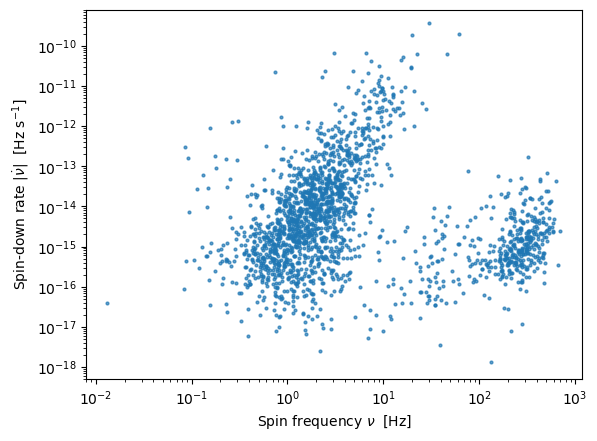

In [138]:
x = df_pulsars['F0']
y = abs(df_pulsars['F1'])
plt.scatter(x, y, marker = '.', s = 16, alpha = 0.7)
plt.xlabel(r'Spin frequency $\nu$  [Hz]')
plt.ylabel(r'Spin-down rate $|\dot{\nu}|$  [Hz s$^{-1}$]')
plt.xscale('log')
plt.yscale('log')
plt.xlim(8e-3, 1.2e3)
plt.ylim(5e-19, 8e-10)
plt.show()

#### Histogram of spin frequency $\nu$

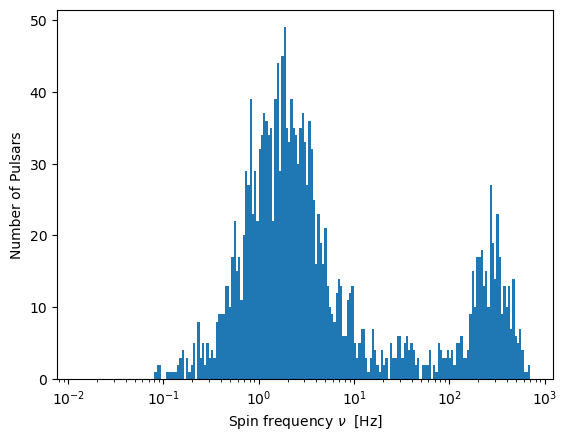

In [140]:
bins_logspace = np.logspace(np.log10(x.min()), np.log10(x.max()), 200)
plt.hist(x, bins = bins_logspace)
plt.xlabel(r'Spin frequency $\nu$  [Hz]')
plt.ylabel('Number of Pulsars')
plt.xscale('log')
plt.show()

#### Histogram of spin-down rate $|\dot{\nu}|$

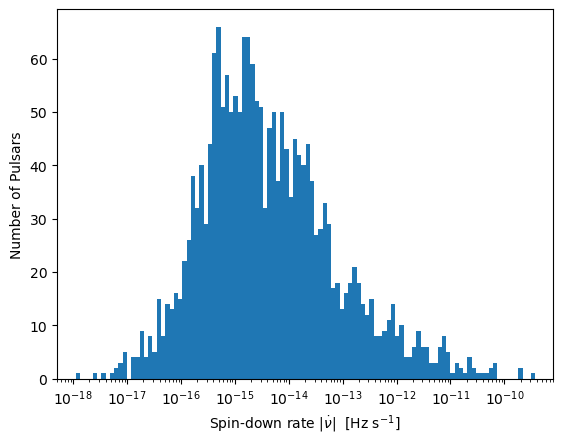

In [142]:
bins_logspace = np.logspace(np.log10(y.min()), np.log10(y.max()), 200)
plt.hist(y, bins = bins_logspace)
plt.xlabel(r'Spin-down rate $|\dot{\nu}|$  [Hz s$^{-1}$]')
plt.ylabel('Number of Pulsars')
plt.xscale('log')
plt.xlim(5e-19, 8e-10)
plt.show()

#### Histogram of distance $d$

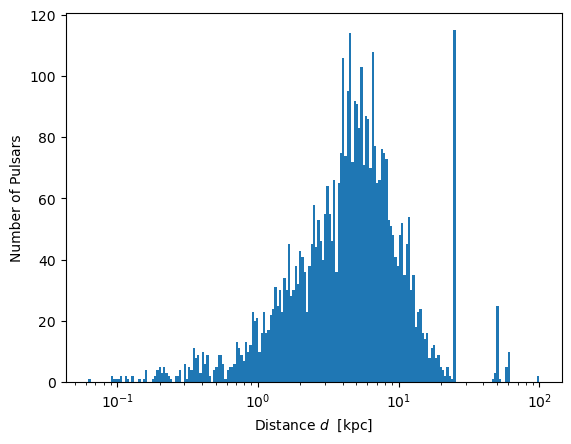

In [144]:
z = df_pulsars['DIST']
bins_logspace = np.logspace(np.log10(z.min()), np.log10(z.max()), 200)
plt.hist(z, bins = bins_logspace)
plt.xlabel(r'Distance $d$  [kpc]')
plt.ylabel('Number of Pulsars')
plt.xscale('log')
plt.show()

One can see that there is an abnormal spike in the number of pulsars with $d = 25~\text{kpc}$. This arises from the analysis from Yao, Manchester & Wang (2017), where they set the distance equal to 25 kpc if the pulsar's dispersion measure (DM) exceeded the range allowable for their electron-density model. It makes sense to remove this artificial spike so we do not bias our results. 

In [146]:
df_pulsars['DIST'] = df_pulsars['DIST'].replace(25, pd.NA)

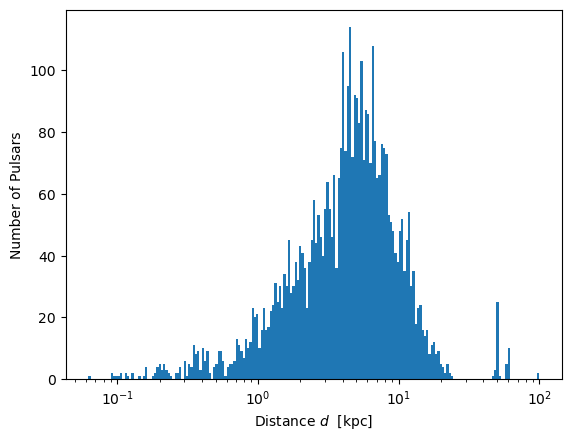

In [147]:
z = df_pulsars['DIST']
bins_logspace = np.logspace(np.log10(z.min()), np.log10(z.max()), 200)
plt.hist(z, bins = bins_logspace)
plt.xlabel(r'Distance $d$  [kpc]')
plt.ylabel('Number of Pulsars')
plt.xscale('log')
plt.show()

#### Sky location of pulsars (Cartesian RA/Dec, Mollweide, Galactic Coordinates)

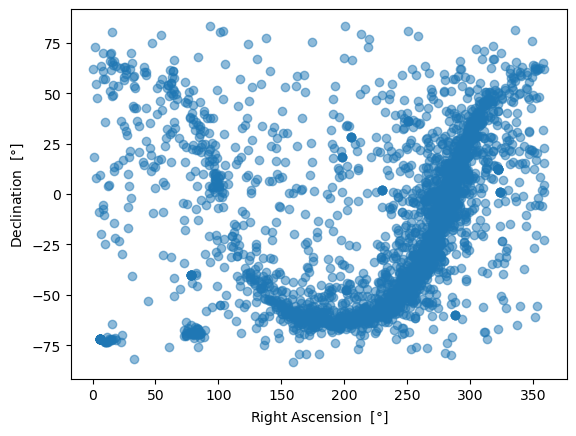

In [149]:
RA = df_pulsars['RA']
DEC = df_pulsars['DEC']
plt.scatter(RA, DEC, alpha = 0.5)
plt.xlabel(r'Right Ascension  [$\degree$]')
plt.ylabel(r'Declination  [$\degree$]')
plt.show()

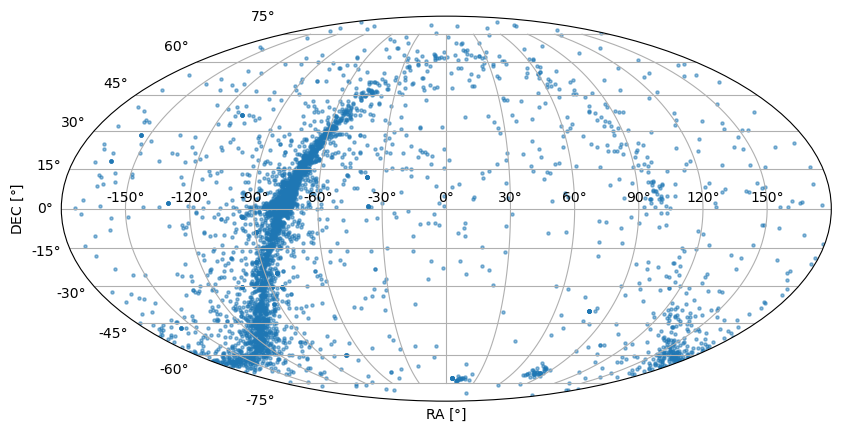

In [150]:
# Convert RA and Dec to radians
RA_rad = np.deg2rad(df_pulsars['RA'])
DEC_rad = np.deg2rad(df_pulsars['DEC'])

# For a Mollweide projection, the RA must be in the range [-180°, 180°] and in radians
RA_rad_wrap = np.remainder(RA_rad + 2*np.pi, 2*np.pi)  # [0, 2pi]
RA_rad_wrap[RA_rad_wrap > np.pi] -= 2*np.pi  # Shift to [-pi, pi]
# RA_rad_wrap = -RA_rad_wrap  # optional: flip so RA increases to the left

plt.figure(figsize=(10,5))
ax = plt.subplot(111, projection='mollweide')
ax.scatter(RA_rad_wrap, DEC_rad, s=5, alpha=0.5)
ax.set_xlabel(r'RA [$\degree$]')
ax.set_ylabel(r'DEC [$\degree$]')
ax.grid()
plt.show()

In [151]:
from astropy.coordinates import SkyCoord
import astropy.units as u

# Convert pd.NA to np.nan for AstroPy to work
RA = df_pulsars['RA'].astype('float64').to_numpy()
DEC = df_pulsars['DEC'].astype('float64').to_numpy()

# Create a SkyCoord object in ICRS (RA/Dec) frame
coords_icrs = SkyCoord(ra = RA * u.degree, dec = DEC * u.degree, frame='icrs')

# Convert to Galactic frame
coords_gal = coords_icrs.galactic

# Add to df_pulsars
df_pulsars['l'] = coords_gal.l.deg   # Galactic longitude in degrees
df_pulsars['b'] = coords_gal.b.deg   # Galactic latitude in degrees

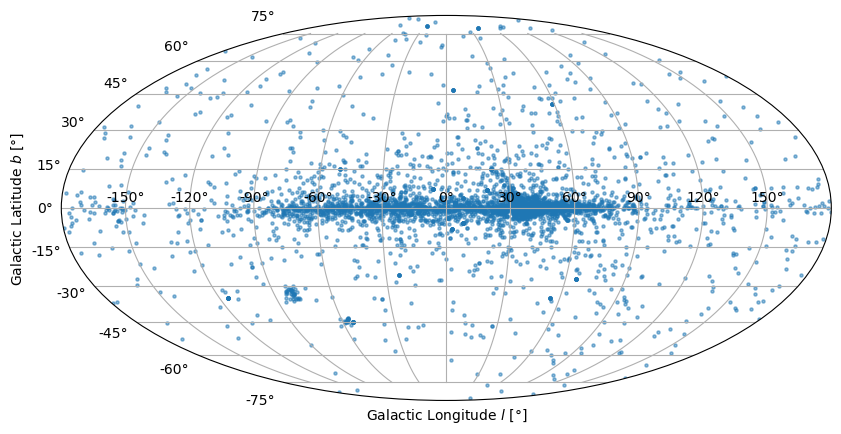

In [152]:
# Convert degrees to radians
l_rad = np.deg2rad(df_pulsars['l'])
b_rad = np.deg2rad(df_pulsars['b'])

# Wrap l to [-180°, 180°] in radians for Mollweide
l_rad_wrap = np.remainder(l_rad + 2 * np.pi, 2 * np.pi)
l_rad_wrap[l_rad_wrap > np.pi] -= 2 * np.pi

plt.figure(figsize = (10,5))
ax = plt.subplot(111, projection = 'mollweide')
ax.scatter(l_rad_wrap, b_rad, s = 5, alpha = 0.5)
ax.set_xlabel(r'Galactic Longitude $l$ [$\degree$]')
ax.set_ylabel(r'Galactic Latitude $b$ [$\degree$]')
ax.grid()
plt.show()

### Visualising glitches from `df_glitch`

#### Change in spin-down rate $\Delta\dot{\nu} / \dot{\nu}$ vs. glitch size $\Delta\nu / \nu$ using linear $y$ scale

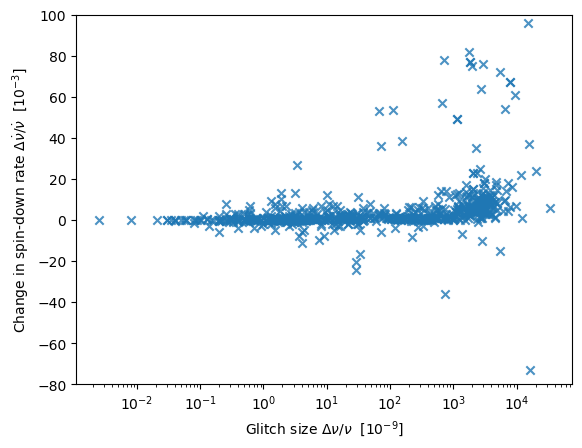

In [155]:
x = df_glitch['dF_F']
y = df_glitch['dF1_F1']
plt.scatter(x, y, marker = 'x', alpha = 0.8)
plt.xlabel(r'Glitch size $\Delta\nu / \nu$  [10$^{-9}$]')
plt.ylabel(r'Change in spin-down rate $\Delta\dot{\nu} / \dot{\nu}$  [10$^{-3}$]')
plt.xscale('log')
plt.ylim(-80, 100)
plt.show()

One can see that we have a few glitches with a negative $\Delta\dot{\nu} / \dot{\nu}$. We will display the positive and negative values on separate graphs as we will need to take logarithms (we cannot take the logarithm of a negative value).

#### Change in spin-down rate $\Delta\dot{\nu} / \dot{\nu}$ (positive values) vs. glitch size $\Delta\nu / \nu$ using logarithmic $y$ scale

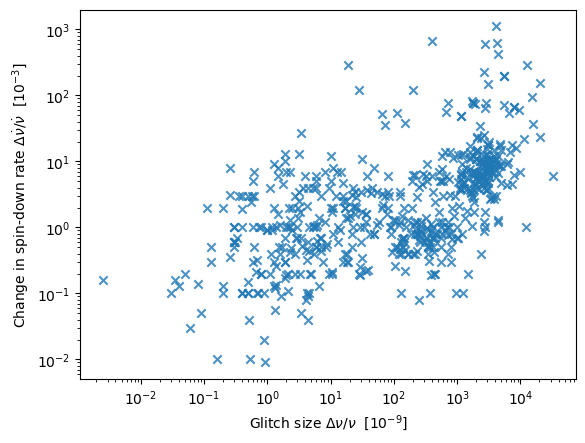

In [158]:
x = df_glitch['dF_F']
y = df_glitch['dF1_F1']
plt.scatter(x, y, marker = 'x', alpha = 0.8)
plt.xlabel(r'Glitch size $\Delta\nu / \nu$  [10$^{-9}$]')
plt.ylabel(r'Change in spin-down rate $\Delta\dot{\nu} / \dot{\nu}$  [10$^{-3}$]')
plt.xscale('log')
plt.yscale('log')
plt.show()

#### Change in spin-down rate $\Delta\dot{\nu} / \dot{\nu}$ (negative values) vs. glitch size $\Delta\nu / \nu$ using logarithmic $y$ scale

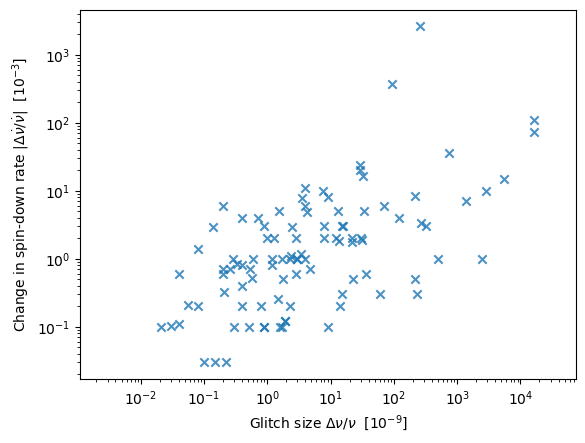

In [160]:
x = df_glitch['dF_F']
y = -df_glitch['dF1_F1']
plt.scatter(x, y, marker = 'x', alpha = 0.8)
plt.xlabel(r'Glitch size $\Delta\nu / \nu$  [10$^{-9}$]')
plt.ylabel(r'Change in spin-down rate $|\Delta\dot{\nu} / \dot{\nu}|$  [10$^{-3}$]')
plt.xscale('log')
plt.yscale('log')
plt.show()

#### Histogram of glitch size

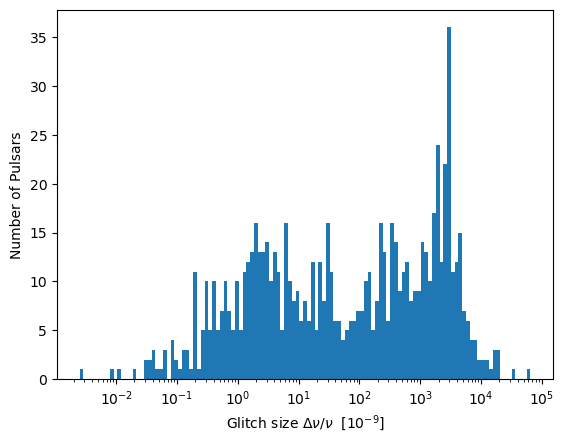

In [162]:
x = df_glitch['dF_F']
bins_logspace = np.logspace(np.log10(x.min()), np.log10(x.max()), 120)
plt.hist(x, bins = bins_logspace)
plt.xlabel(r'Glitch size $\Delta\nu / \nu$  [10$^{-9}$]')
plt.ylabel('Number of Pulsars')
plt.xscale('log')
plt.show()

#### Histogram of change in spin-down rate (positive values)

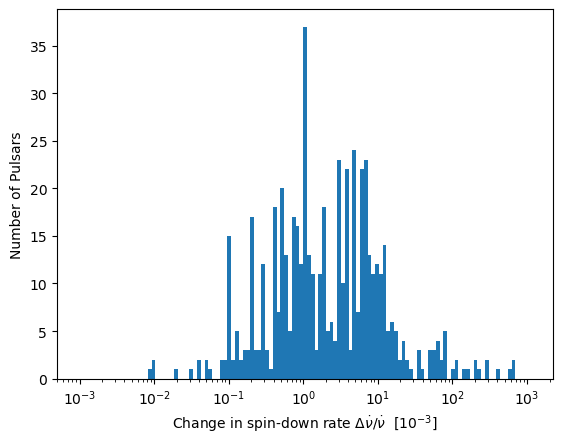

In [164]:
y = df_glitch['dF1_F1']
bins_logspace = np.logspace(-3, np.log10(y.max()), 120)
plt.hist(y, bins = bins_logspace)
plt.xlabel(r'Change in spin-down rate $\Delta\dot{\nu} / \dot{\nu}$  [10$^{-3}$]')
plt.ylabel('Number of Pulsars')
plt.xscale('log')
plt.show()

#### Histogram of change in spin-down rate (negative values)

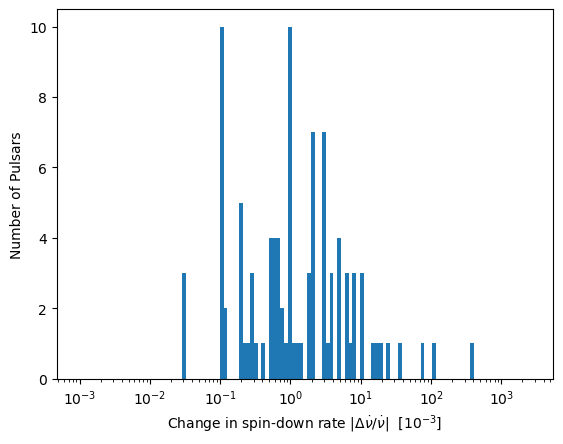

In [166]:
y = -df_glitch['dF1_F1']
bins_logspace = np.logspace(-3, np.log10(y.max()), 120)
plt.hist(y, bins = bins_logspace)
plt.xlabel(r'Change in spin-down rate $|\Delta\dot{\nu} / \dot{\nu}|$  [10$^{-3}$]')
plt.ylabel('Number of Pulsars')
plt.xscale('log')
plt.show()

#### Cumulative number of glitches as a function of MJD

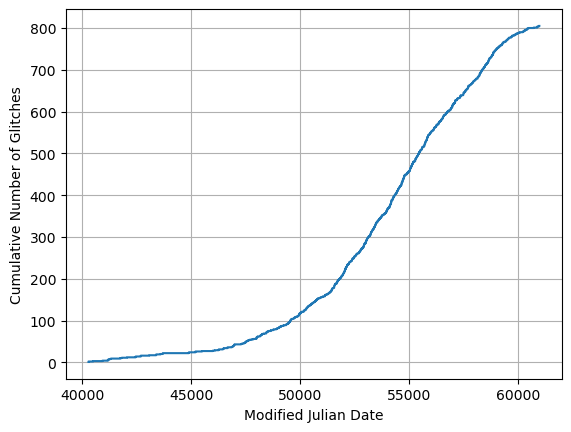

In [168]:
df_sorted = pd.DataFrame(df_glitch['MJD'].sort_values())
df_sorted = df_sorted.reset_index(drop = True)

plt.step(df_sorted['MJD'], df_sorted.index + 1, where='post')
plt.xlabel('Modified Julian Date')
plt.ylabel('Cumulative Number of Glitches')
plt.grid()
plt.show()

#### Histogram of waiting times

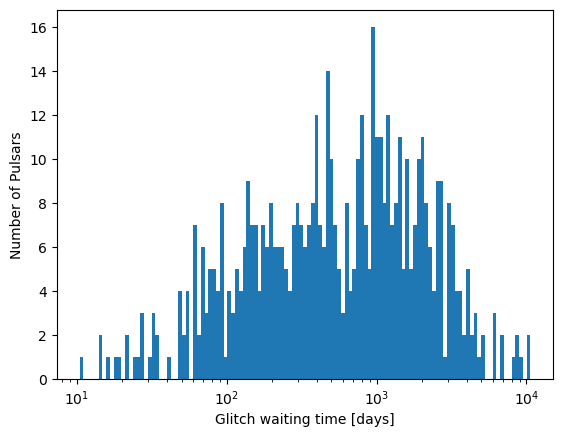

In [170]:
df_glitch = df_glitch.sort_values(by = ['J_name', 'MJD'])
df_glitch['MJD_diff'] = df_glitch.groupby('J_name')['MJD'].diff()

x = df_glitch['MJD_diff'].replace(0, pd.NA)
x[x < 2] = pd.NA # Removes 2 datapoints stemming from Vela's multiple component recovery
bins_logspace = np.logspace(np.log10(x.min()), np.log10(x.max()), 120)
plt.hist(x, bins = bins_logspace)
plt.xlabel(r'Glitch waiting time [days]')
plt.ylabel('Number of Pulsars')
plt.xscale('log')
plt.show()

---
# PART II - Applying Machine Learning


In this part of the project, we wish to apply machine learning models to `df_glitch` and `df_pulsars`. For now, we will only focus on predicting the distribution of glitch sizes and waiting times, and we will hopefully unveil some pulsar properties that are key in making these predictions. 

To do this, we need to complete the following steps:
1. Categorise each pulsar's glitch size and waiting time distributions into one of the following:
   - Power law  $p(x | \vec{\theta}) = \frac{\alpha - 1}{x_\text{min}} \left(\frac{x}{x_\text{min}} \right)^{-\alpha}$
   - Exponential  $p(x | \vec{\theta}) = \lambda \exp[-\lambda(x - x_\text{min})]$
   - Gaussian/Normal  $p(x | \vec{\theta}) = \frac{1}{\sqrt{2 \pi} \sigma}  \exp[-\frac{(x - \mu)^2}{2\sigma^2}]$
   - Log normal  $p(x | \vec{\theta}) = \frac{1}{x \sqrt{2 \pi} \sigma}  \exp[-\frac{(\ln x - \mu)^2}{2\sigma^2}]$
2. These act as our labels for supervised machine learning. We will then split our data into training, validation and test data and then apply the following models:
   - Random forest - this is an example of a bagging model
   - XGBoost - this is an example of a boosting model
3. Finally, we will evaluate the performance of our models and use the best model to determine which pulsar properties are most important when it comes to predicting the glitch size and waiting time distributions.

## Creating training labels

### Selecting pulsars with 5 or more glitches

We want to choose pulsars with a sufficient amount of glitches for the distribution fittings to make sense. We arbitrarily choose a minimum of 5 glitches for a pulsar to be considered. 

In [176]:
df_5 = df_glitch[df_glitch.groupby('J_name')['MJD'].transform('count') >= 5] # Dataframe of pulsars with 5 or more glitches
df_5.nunique()

J_name                   39
pulsar_glitch_number     65
MJD                     451
MJD_err                  75
dF_F                    385
                       ... 
W50                      31
DEC                      39
RA                       39
DIST                     36
MJD_diff                397
Length: 178, dtype: int64

We find that there are 39 pulsars that have 5 or more glitches. This will form our dataset used for machine learning. It is not a large quantity but this is what we have to deal with. As more glitches are observed in the future, this number will increase.

### Glitch size distribution

In this section, we will fit 4 distributions (power law, exponential, log-normal, Gaussian) to each pulsar's distribution of glitch sizes. To do this, we will use the maximum likelihood estimator (MLE) to determine the 'best' parameter(s) for each model, e.g. finding the best $\mu$ and $\sigma$ for the log-normal and Gaussian distributions, and then calculate the log-likelihood of each model (the probability of the data, given the distribution).

$\mathcal{L} = \prod_{i}^{N}~p(x_i | \vec{\theta}) ~~\rightarrow~~ \ln(\mathcal{L}) = \sum_{i}^{N} \ln (p(x_i | \vec{\theta}))$

The log-likelihood, $\ln(\mathcal{L})$, is normally negative, and a more positive value suggests a better fit. We use the package `powerlaw` (Alstott, Bullmore & Plenz, 2014) to fit power law, exponential and log-normal distributions and we use `scipy` to fit Gaussian distributions (the `powerlaw` distribution doesn't allow Gaussian fitting as it is mostly concerned about heavy-tailed distributions). 

To ensure a fair comparison between models, we must somehow penalise more complex distributions (with more parameters), so we use the Akaike Information Criterion (AIC), which is given by:

$\text{AIC} = -2\ln(\mathcal{L}) + 2k$

where $\mathcal{L} = p(x | \vec{\theta})$ is the likelihood and $k$ is the number of free parameters in the distribution. With the AIC, the *lower* the value, the better the fit. We could have equally used the Bayesian Information Criterion (BIC) but this often favours simpler models (leading to lower prediction accuracy) than AIC which tends to favour more complex models (leading to a better prediction accuracy). BIC is useful when you have a lot of data, but we do not have much to work with here.

For more information about AIC, see Appendix A of Fuentes et al. (2017).


In [180]:
# Creating a dictionary with key as J_name and value as an array of glitch sizes
glitch_sizes = {
    pulsar : glitch_size_array.values for pulsar, glitch_size_array in df_5.groupby('J_name')['dF_F']
}

In [181]:
# To hold the name of the best glitch size distribution
best_dist_for_pulsar = {} 

In [182]:
%%capture 
# Cell magic above prevents anything from this cell from being printed out (including warnings)

# Use powerlaw package to fit power law, exponential and log-normal distributions, normal distribution treated separately using SciPy
for pulsar, data in glitch_sizes.items():
    # Apply powerlaw.Fit to the data to find xmin so we can truncate the data at low x (assumes data is heavy-tailed, e.g. has a power law for large x). This truncation allows for a fair comparison of models.
    fit = powerlaw.Fit(data, xmin = None) # xmin = None allows the algorithm to calculate the optimal one by selecting the xmin giving the smallest Kolmogorov-Smirnov distance (smallest distance between model and actual CDFs)

    # Fitting different distributions to the data
    power_dist = fit.power_law
    exp_dist = fit.exponential
    ln_dist = fit.lognormal

    # Getting the optimal value for xmin (xmin will be the same for each distribution, so fit.xmin = power_dist.xmin = exp_dist.xmin = ln_dist.xmin)
    xmin = fit.xmin # Essentially the lower cut-off value, calculated by minimizing the KS distance for different values of xmin

    # Optimal fitting parameters (if needed)
    alpha_opt = power_dist.alpha
    lambda_opt = exp_dist.Lambda
    mu_opt_ln = ln_dist.mu
    sigma_opt_ln = ln_dist.sigma
    
    # Getting rid of everything under xmin to make Gaussian fit fair and comparable
    data_truncated = data[data >= xmin]
    mu_opt_norm, sigma_opt_norm = norm.fit(data_truncated)
    
    # Calculating the log-likelihood for each optimally-fitted distribution (a more positive log-likelihood is better)
    logL_power = power_dist.loglikelihoods(data).sum()
    logL_exp = exp_dist.loglikelihoods(data).sum()
    logL_ln = ln_dist.loglikelihoods(data).sum()
    logL_norm = norm.logpdf(data_truncated, mu_opt_norm, sigma_opt_norm).sum()

    # Calculating the Akaike Information Criterion (AIC)
    AIC_power = - 2.0 * logL_power + 2.0 * 1 # Power law has 1 free parameter (alpha)
    AIC_exp = - 2.0 * logL_exp + 2.0 * 1 # Exponential has 1 free parameter (lambda)
    AIC_ln = - 2.0 * logL_ln + 2.0 * 2 # Log-normal has 2 free parameters (mu and sigma)
    AIC_norm = - 2.0 * logL_norm + 2.0 * 2 # Normal has 2 free parameters (mu and sigma)

    # Calculating the Akaike weights to tell us the probability that a particular model is the true model (see Appendix A of Fuentes et al. 2017)
    AIC_min = min(AIC_power, AIC_exp, AIC_ln, AIC_norm)
    
    Delta_power = AIC_power - AIC_min
    Delta_exp = AIC_exp - AIC_min
    Delta_ln = AIC_ln - AIC_min
    Delta_norm = AIC_norm - AIC_min

    sum_of_deltas = sum([np.exp(-Delta_power/2.0), np.exp(-Delta_exp/2.0), np.exp(-Delta_ln/2.0), np.exp(-Delta_norm/2.0)])

    weight_power = np.exp(-Delta_power/2.0) / sum_of_deltas
    weight_exp = np.exp(-Delta_exp/2.0) / sum_of_deltas
    weight_ln = np.exp(-Delta_ln/2.0) / sum_of_deltas
    weight_norm = np.exp(-Delta_norm/2.0) / sum_of_deltas

    weights = [weight_power, weight_exp, weight_ln, weight_norm]

    # Selecting the most probable distribution
    most_probable_weight = max(weights)
    most_probable_index = weights.index(most_probable_weight)
    dists = ['Power', 'Exponential', 'Log-normal', 'Gaussian']
    best_dist = dists[most_probable_index]

    # Appending the best distribution to a dictionary outside the for loop (to be mapped onto df_pulsar) 
    best_dist_for_pulsar[pulsar] = best_dist
    
    # print(pulsar, xmin, '|', '{:.2f}'.format(AIC_power), '{:.2f}'.format(AIC_exp), 
    #       '{:.2f}'.format(AIC_ln), '{:.2f}'.format(AIC_norm), '|', 
    #       '{:.2f}'.format(weight_power), '{:.2f}'.format(weight_exp), 
    #       '{:.2f}'.format(weight_ln), '{:.2f}'.format(weight_norm), '|', '{:.2f}'.format(most_probable_weight), best_model)


In [183]:
df_pulsars['glitch_dist'] = df_pulsars['J_name'].map(best_dist_for_pulsar)

### Waiting time distribution

We will return to this at a later date. Let's ensure the ML algorithm works for glitch sizes first.

## Feature engineering

### Encoding `glitch_dist` to numerical type

In [188]:
df_size = df_pulsars[df_pulsars['glitch_dist'].notna()].copy() # Pulls out only the pulsars that have a glitch size distribution

In [189]:
le = LabelEncoder()
df_size.loc[:, 'glitch_dist_en'] = le.fit_transform(df_size['glitch_dist']) # 'glitch_dist_en' holds encoding of 'glitch_dist', use le.inverse_transform(df_size['glitch_dist_en']) later to recover original labels

### Removing obvious columns  

In [191]:
df_size = df_size.drop(columns = ['DIST_A', 'DIST_AMN', 'DIST_AMX', 'DIST_DM', 'DIST_DM1', 'PX']) # Drop all distance measures as we already have 'DIST'
df_size = df_size.drop(columns = ['DMEPOCH', 'PEPOCH', 'POSEPOCH']) # Drop all 'EPOCH' measurements - they are just for bookkeeping to record when measurements were made
df_size = df_size.loc[:, df_size.count() >= 10] # Removes all columns with less than 10 entries
df_size = df_size.select_dtypes(include = ['number']) # Keeps all numerical columns

df_size.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, 123 to 4294
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DM              35 non-null     Float64
 1   F0              35 non-null     Float64
 2   F1              35 non-null     Float64
 3   F2              30 non-null     Float64
 4   NGLT            39 non-null     Int64  
 5   PMDEC           16 non-null     Float64
 6   PMRA            16 non-null     Float64
 7   RM              30 non-null     Float64
 8   S1284           17 non-null     Float64
 9   S1400           36 non-null     Float64
 10  S3000           22 non-null     Float64
 11  S400            16 non-null     Float64
 12  S5000           10 non-null     Float64
 13  S600            15 non-null     Float64
 14  S900            11 non-null     Float64
 15  SPINDX          28 non-null     Float64
 16  TAU_SC          19 non-null     Float64
 17  W10             30 non-null     Float6

With the simple procedures above:
- Remove `DIST_A`, `DIST_AMN`, `DIST_AMX`, `DIST_DM`, `DIST_DM1` and `PX` (already have `DIST`)
- Remove columns with less than 10 entries
- Keeping only numerical columns (plus the 1 object column, `glitch_dist`)
  
We have gone from the original 168 columns down to 25 columns.

We will further explore the correlation between these features to see if any could be removed.

### Removing highly correlated features

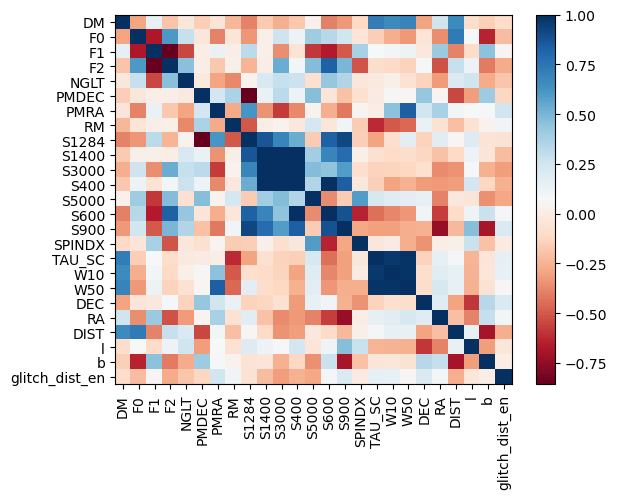

In [194]:
data = df_size.corr()

fig, ax = plt.subplots()
image = ax.pcolor(data, cmap='RdBu')

# Label names
row_labels = data.columns
col_labels = data.index

# Move ticks and labels to the center
ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)

# Inserting labels
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(col_labels, minor=False)

# Rotate label
plt.xticks(rotation=90)

# Invert y axis so that diagonal has negative slope
plt.gca().invert_yaxis()
fig.colorbar(image)
plt.show()

We can see that `S1400` has a strong positive correlation with `S3000`, `S400`, `S1284` and `S900`. This is unsurprising as these quantities measure the radio flux at different observing radio frequencies (1400, 3000, 400, 1284, 900 MHz, respectively). Since `S1400` has the most entries, we will keep that and remove the other four.

There is also a strong correlation between `W50` and `W10`, both being measures of pulse width. We will keep `W50` as we have more entries.

In [196]:
df_size = df_size.drop(columns = ['S3000', 'S400', 'S1284', 'S900', 'W10'])

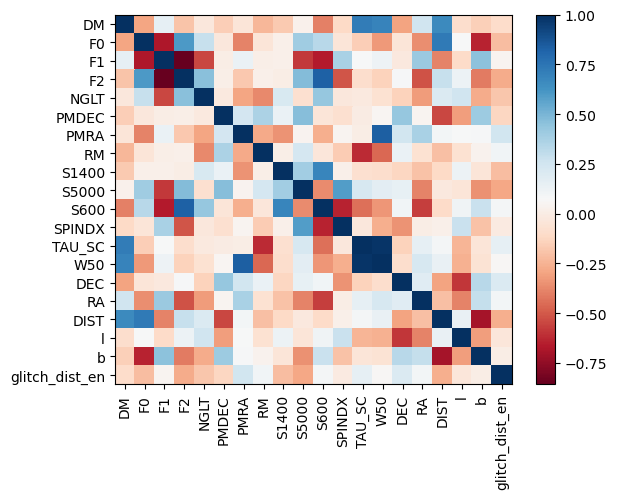

In [197]:
data = df_size.corr()

fig, ax = plt.subplots()
image = ax.pcolor(data, cmap='RdBu')

# Label names
row_labels = data.columns
col_labels = data.index

# Move ticks and labels to the center
ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)

# Inserting labels
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(col_labels, minor=False)

# Rotate label
plt.xticks(rotation=90)

# Invert y axis so that diagonal has negative slope
plt.gca().invert_yaxis()
fig.colorbar(image)
plt.show()

We can see that we have removed several highly-correlated features that also make sense from domain experience. We now have 20 features instead of the original 168. Note that `F0`, `F1` and `F2` should be kept in, even though they have strong correlations, as they are often of interest to many researchers. Likewise, we have kept `TAU_SC` (temporal broadening due to interstellar scattering) and `W50` (width of pulse, 50% down from the peak) as one is temporal broadening whereas the other is spatial.

## Applying random forest with stratisfied 5-fold cross-validation

### Finding best hyperparameters

In [201]:
X = df_size.drop(columns = 'glitch_dist_en')
y = df_size['glitch_dist_en']

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 77, stratify = y)

# Creating pipeline, need to have imputer to ensure no NaNs, cannot remove rows with NaN since already small sample size
pipeline = Pipeline(
    [('imputer', SimpleImputer(strategy = 'median')), 
     ('scaler', StandardScaler()), 
     ('pca', PCA(random_state = 77)),
     ('rf', RandomForestClassifier(random_state = 77))]
)

# Hyperparameter search grid
param_grid = {
    'pca__n_components': [2, 3, 4, 5, 6],
    'rf__n_estimators': [30, 35, 40, 45, 50],
    'rf__max_depth' : [None, 2, 3, 4]
}

# Stratified 5-fold cross validation
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 77)

# Conducting GridSearchCV to find the best hyperparameters
best_model = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = cv, scoring = 'accuracy')

# Fitting best model to training data
best_model.fit(X_train, y_train)

print("Best parameters: ", best_model.best_params_)
print("Best score: ", best_model.best_score_) # This is the average accuracy score on the k validation sets

# df_size['glitch_dist'] = le.inverse_transform(df_size['glitch_dist_en']) 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best parameters:  {'pca__n_components': 3, 'rf__max_depth': 3, 'rf__n_estimators': 40}
Best score:  0.6571428571428571


/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


### Evaluating predictive performance on training data

Training Accuracy:  0.8064516129032258
Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.64      0.78        11
           1       0.00      0.00      0.00         2
           2       0.75      1.00      0.86        18

    accuracy                           0.81        31
   macro avg       0.58      0.55      0.54        31
weighted avg       0.79      0.81      0.77        31



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


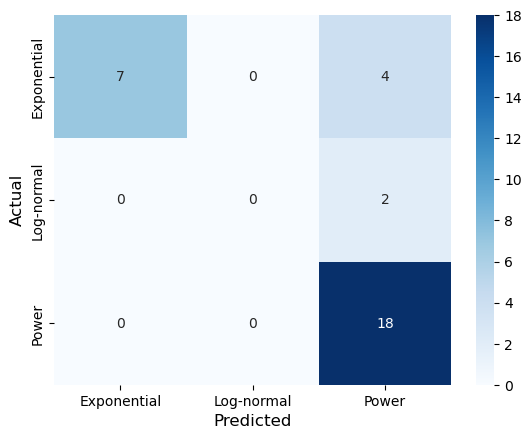

In [203]:
# Using best_model to see how good predicting training data is
y_train_pred = best_model.predict(X_train)

# Some statistics to tell us the goodness-of-fit (e.g. accuracy, precision, recall, F1 score)
print('Training Accuracy: ', accuracy_score(y_train, y_train_pred))
print('Classification report: \n', classification_report(y_train, y_train_pred))

# Confusion matrix
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
fig, ax = plt.subplots(1, 1)
sns.heatmap(conf_matrix_train, annot = True, cmap = 'Blues', fmt = 'd', ax = ax, xticklabels = le.classes_, yticklabels = le.classes_)
ax.set_xlabel('Predicted', size = 12);
ax.set_ylabel('Actual', size = 12);

### Evaluating predictive performance on test data

Test Accuracy:  0.625
Classification report: 
               precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           2       0.67      0.80      0.73         5

    accuracy                           0.62         8
   macro avg       0.58      0.57      0.56         8
weighted avg       0.60      0.62      0.60         8



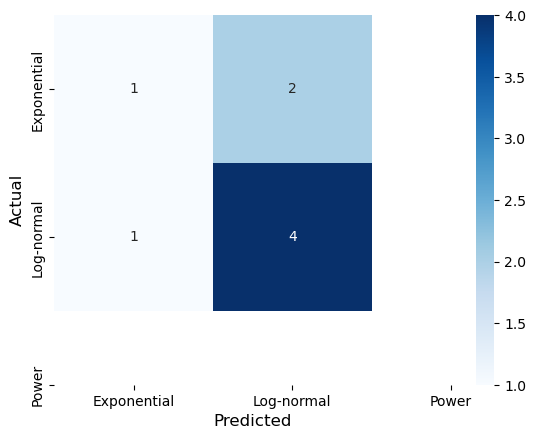

In [205]:
# Using best_model to see how good predicting test data is
y_test_pred = best_model.predict(X_test)

# Some statistics to tell us the goodness-of-fit (e.g. accuracy, precision, recall, F1 score)
print('Test Accuracy: ', accuracy_score(y_test, y_test_pred))
print('Classification report: \n', classification_report(y_test, y_test_pred))

# Confusion matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(1, 1)
sns.heatmap(conf_matrix_test, annot = True, cmap = 'Blues', fmt = 'd', ax = ax, xticklabels = le.classes_, yticklabels = le.classes_)
ax.set_xlabel('Predicted', size = 12);
ax.set_ylabel('Actual', size = 12);

Note that there are some issues with the display above. The test dataset did not contain any pulsars with a log-normal glitch size distribution so we lost a row and column. The confusion matrix is correct if you remove the central log-normal column/row.

### Feature importance (when PCA and imputer in pipeline)

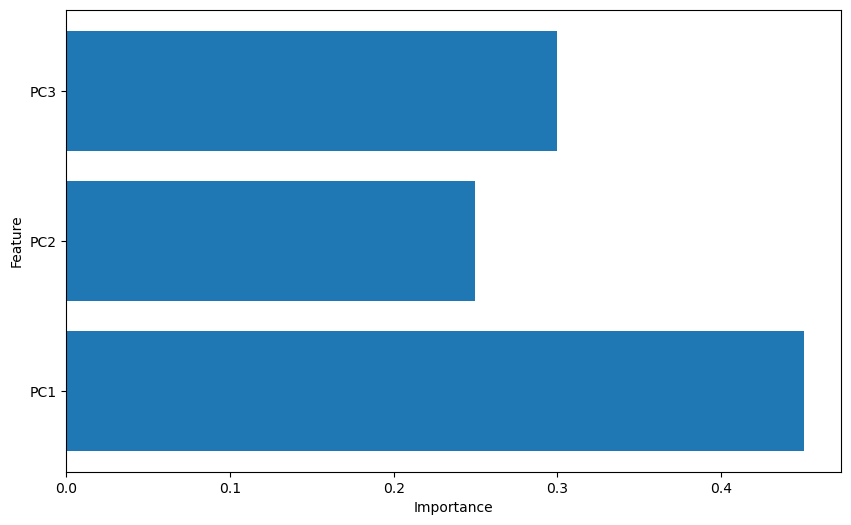

In [208]:
PCA_importances = best_model.best_estimator_.named_steps['rf'].feature_importances_

plt.figure(figsize=(10,6))
plt.barh(['PC1', 'PC2', 'PC3'], PCA_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

We see from above that we only get the feature importance of the principal components of which there were 3. Initially, we had 19 features and "compressed" all the information into only 3 components. We have therefore lost information. We won't be able to reconstruct the original features so we have no way to find which features are the most important. Instead, we repeat the entire algorithm below but without PCA in order to keep interpretability.

### Repeating without PCA but with imputer (didn't yet know I didn't need imputer)

#### Hyperparameter tuning

In [212]:
X = df_size.drop(columns = 'glitch_dist_en')
y = df_size['glitch_dist_en']

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 77, stratify = y)

# Creating pipeline, need to have imputer to ensure no NaNs, cannot remove rows with NaN since already small sample size
pipeline = Pipeline(
    [('imputer', SimpleImputer(strategy = 'median')), 
     ('scaler', StandardScaler()), 
     # ('pca', PCA(random_state = 77)),
     ('rf', RandomForestClassifier(random_state = 77))]
)

# Hyperparameter search grid
param_grid = {
    # 'pca__n_components': [2, 3, 4, 5, 6],
    'rf__n_estimators': [30, 35, 40, 45, 50],
    'rf__max_depth' : [None, 2, 3, 4]
}

# Stratified 5-fold cross validation
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 77)

# Conducting GridSearchCV to find the best hyperparameters
best_model = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = cv, scoring = 'accuracy')

# Fitting best model to training data
best_model.fit(X_train, y_train)

print("Best parameters: ", best_model.best_params_)
print("Best score: ", best_model.best_score_) # This is the average accuracy score on the k validation sets

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best parameters:  {'rf__max_depth': 2, 'rf__n_estimators': 40}
Best score:  0.6523809523809524


We see that the best validation accuracy has only dropped by 0.00476 (0.476%) so the drop in accuracy is worth the increase in interpretability. After all, this is one of the benefits of using random forest, which is that it is complex enough to discover complicated non-linear relations. 

#### Evaluating predictive performance on training data

Training Accuracy:  0.8709677419354839
Classification report: 
               precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.00      0.00      0.00         2
           2       0.89      0.94      0.92        18

    accuracy                           0.87        31
   macro avg       0.58      0.62      0.60        31
weighted avg       0.82      0.87      0.84        31



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


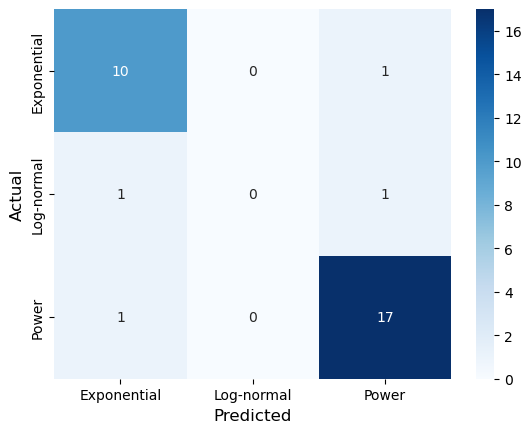

In [215]:
# Using best_model to see how good predicting training data is
y_train_pred = best_model.predict(X_train)

# Some statistics to tell us the goodness-of-fit (e.g. accuracy, precision, recall, F1 score)
print('Training Accuracy: ', accuracy_score(y_train, y_train_pred))
print('Classification report: \n', classification_report(y_train, y_train_pred))

# Confusion matrix
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
fig, ax = plt.subplots(1, 1)
sns.heatmap(conf_matrix_train, annot = True, cmap = 'Blues', fmt = 'd', ax = ax, xticklabels = le.classes_, yticklabels = le.classes_)
ax.set_xlabel('Predicted', size = 12);
ax.set_ylabel('Actual', size = 12);

We actually see an improvement to the training accuracy. This is a sign that we may be overfitting. We will be able to confirm below when we evaluate the model on test data.

#### Evaluating predictive performance on test data

Test Accuracy:  0.5
Classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           2       0.57      0.80      0.67         5

    accuracy                           0.50         8
   macro avg       0.29      0.40      0.33         8
weighted avg       0.36      0.50      0.42         8



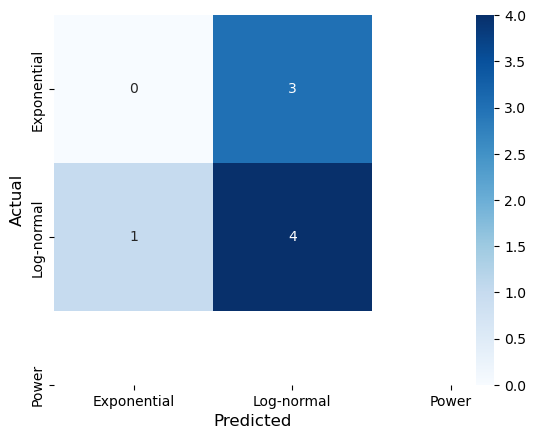

In [218]:
# Using best_model to see how good predicting test data is
y_test_pred = best_model.predict(X_test)

# Some statistics to tell us the goodness-of-fit (e.g. accuracy, precision, recall, F1 score)
print('Test Accuracy: ', accuracy_score(y_test, y_test_pred))
print('Classification report: \n', classification_report(y_test, y_test_pred))

# Confusion matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(1, 1)
sns.heatmap(conf_matrix_test, annot = True, cmap = 'Blues', fmt = 'd', ax = ax, xticklabels = le.classes_, yticklabels = le.classes_)
ax.set_xlabel('Predicted', size = 12);
ax.set_ylabel('Actual', size = 12);

The lower accuracy comfirms our suspicion that we have overfitted to the training data. This is likely because we have 19 features to fit rather than the 3 principal components. Nevertheless, let us now see what features where the most important in this fitting.

#### Feature importance (without PCA but with imputer)

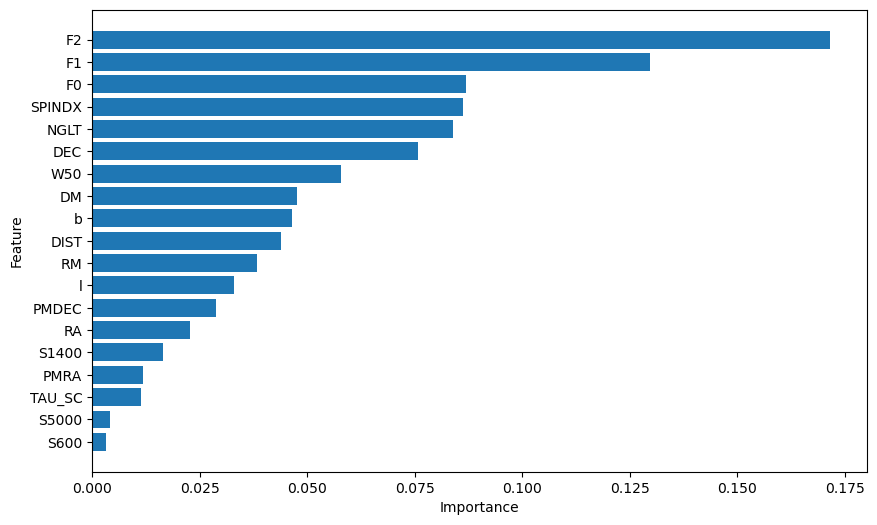

In [221]:
importances = best_model.best_estimator_.named_steps['rf'].feature_importances_

feature_importance = pd.DataFrame({
    'feature' : X.columns,
    'importance' : importances
})

feature_importance = feature_importance.sort_values(by = 'importance')

plt.figure(figsize=(10,6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

After our analysis, we have found that `F2`, `F1` and `F0` (second time-derivative of spin, first time-derivative of spin and spin rate) are the most important features when it comes to determining the glitch size distribution. Physically, this makes sense as these three features are physical (not dependent on chance, like the position in the sky). 

More interestingly, we find that `SPINDX` is also an indicator of the distribution type. This is really interesting because `SPINDX` refers to the radio spectral index, i.e. the exponent in the power law that models the radio emission spectrum. This suggests perhaps pulsars with a particularly hard/soft radio spectrum favour a particular glitch size distribution.

There is a huge caveat to these finding though. The weakest part of this analysis is the fact that we had to impute missing values (we replaced missing values with the median value). This is clearly not correct and a better method should be used. In fact, when testing, I found that when we do not use PCA, we do not need to impute values, so let us try again without PCA or an imputer.

### Repeating without PCA or imputer

#### Hyperparameter tuning

In [225]:
X = df_size.drop(columns = 'glitch_dist_en')
y = df_size['glitch_dist_en']

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 77, stratify = y)

# Creating pipeline, need to have imputer to ensure no NaNs, cannot remove rows with NaN since already small sample size
pipeline = Pipeline(
    [#('imputer', SimpleImputer(strategy = 'median')), 
     ('scaler', StandardScaler()), 
     # ('pca', PCA(random_state = 77)),
     ('rf', RandomForestClassifier(random_state = 77))]
)

# Hyperparameter search grid
param_grid = {
    # 'pca__n_components': [2, 3, 4, 5, 6],
    'rf__n_estimators': [30, 35, 40, 45, 50],
    'rf__max_depth' : [None, 2, 3, 4]
}

# Stratified 5-fold cross validation
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 77)

# Conducting GridSearchCV to find the best hyperparameters
best_model = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = cv, scoring = 'accuracy')

# Fitting best model to training data
best_model.fit(X_train, y_train)

print("Best parameters: ", best_model.best_params_)
print("Best score: ", best_model.best_score_) # This is the average accuracy score on the k validation sets

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best parameters:  {'rf__max_depth': 3, 'rf__n_estimators': 35}
Best score:  0.7809523809523811


This is much better than before when we imputed and better than both cases when we used and didn't use PCA.

#### Evaluating predictive performance on training data

Training Accuracy:  0.9354838709677419
Classification report: 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.50      0.67         2
           2       0.94      0.94      0.94        18

    accuracy                           0.94        31
   macro avg       0.95      0.81      0.86        31
weighted avg       0.94      0.94      0.93        31



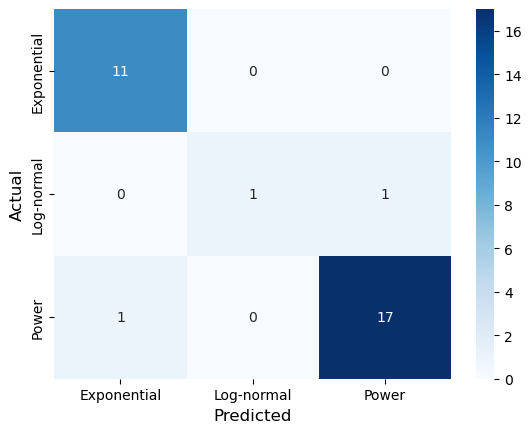

In [228]:
# Using best_model to see how good predicting training data is
y_train_pred = best_model.predict(X_train)

# Some statistics to tell us the goodness-of-fit (e.g. accuracy, precision, recall, F1 score)
print('Training Accuracy: ', accuracy_score(y_train, y_train_pred))
print('Classification report: \n', classification_report(y_train, y_train_pred))

# Confusion matrix
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
fig, ax = plt.subplots(1, 1)
sns.heatmap(conf_matrix_train, annot = True, cmap = 'Blues', fmt = 'd', ax = ax, xticklabels = le.classes_, yticklabels = le.classes_)
ax.set_xlabel('Predicted', size = 12);
ax.set_ylabel('Actual', size = 12);

This training score is much better than the previous models.

#### Evaluating predictive performance on test data

Test Accuracy:  0.5
Classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           2       0.57      0.80      0.67         5

    accuracy                           0.50         8
   macro avg       0.29      0.40      0.33         8
weighted avg       0.36      0.50      0.42         8



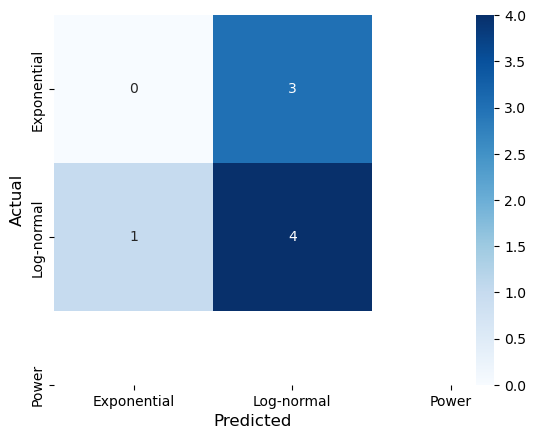

In [231]:
# Using best_model to see how good predicting test data is
y_test_pred = best_model.predict(X_test)

# Some statistics to tell us the goodness-of-fit (e.g. accuracy, precision, recall, F1 score)
print('Test Accuracy: ', accuracy_score(y_test, y_test_pred))
print('Classification report: \n', classification_report(y_test, y_test_pred))

# Confusion matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(1, 1)
sns.heatmap(conf_matrix_test, annot = True, cmap = 'Blues', fmt = 'd', ax = ax, xticklabels = le.classes_, yticklabels = le.classes_)
ax.set_xlabel('Predicted', size = 12);
ax.set_ylabel('Actual', size = 12);

This test accuracy is not that great, but at least the model had learnt the training data well. This is probably more important than making predictions as we just want to know what features are most important based on historical data.

#### Feature importance (without PCA or imputer)

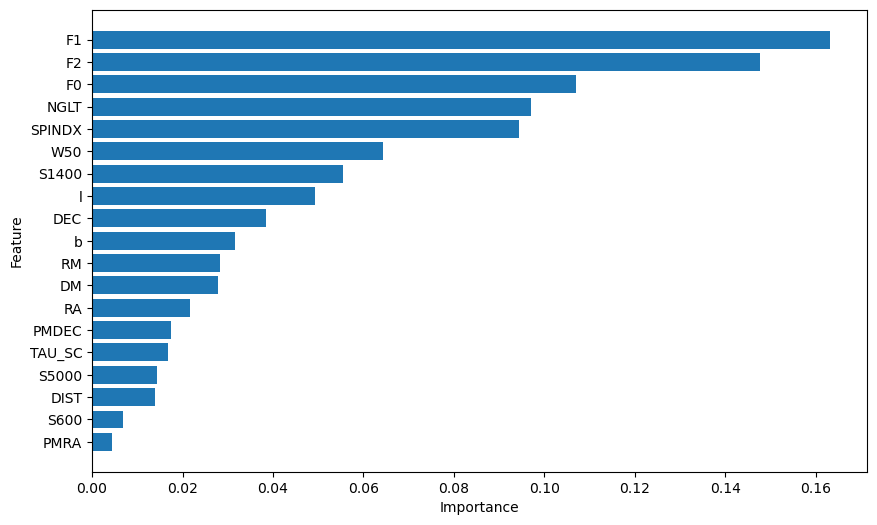

In [234]:
importances = best_model.best_estimator_.named_steps['rf'].feature_importances_

feature_importance = pd.DataFrame({
    'feature' : X.columns,
    'importance' : importances
})

feature_importance = feature_importance.sort_values(by = 'importance')

plt.figure(figsize=(10,6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

This is similar to our earlier analysis, though the positions of `F2` and `F1` have switched around. The same conclusion still stands - all the spin variables and the radio spectral index are still important when it comes to determining the glitch size distribution.